In [1]:
import os
os.chdir('../')

In [2]:
import argparse
import logging
import os
from pathlib import Path
from collections import OrderedDict
from glob import glob

import pandas as pd
import numpy as np
import torch
import gzip
from git import Repo
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, ModelCheckpoint, Timer, global_step_from_engine
from ignite.metrics import Loss, MeanSquaredError

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.express as px

from models import MultitaskFinetune
from utils import load_config, load_model, prepare_batch
import wandb
import utils
from dataloader.labels import get_labels
from dataloader.data import get_tables, MIMICDataset
from dataloader.utils import BinnedEvent, get_vocab
from tqdm.autonotebook import tqdm

In [3]:
DEVICE = 'cuda'
RUN_ID = '2xdwyub7'
LISTFILE_ROOT = '/home/ashankar/mimic3_data/data/'
LISTFILE = 'val_listfile'
THRES = 0.4 # 0.5 precision, 0.8 recall

params = load_config(RUN_ID)
params['patient_modelcls'], params['modelcls']

/home/oserbetci/ICU-RL/utils.py:387: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  c = yaml.load(f)


('models.PatientChannelRNNMaxPoolEncoder', 'models.MultitaskFinetune')

In [4]:
MARKER_COLOR_T = list(zip(['chartevents', 'labevents', 'outputevents', 'prescriptions', 'inputevents_*'], 
                          ['circle-open', 'square-open', 'pentagon-open', 'triangle-up-open', 'star-diamond-open'],
                          px.colors.qualitative.Plotly))
COLOR_DICT = dict(map(lambda x: (x[0], x[2]), MARKER_COLOR_T))
MARKER_DICT = dict(map(lambda x: (x[0], x[1]), MARKER_COLOR_T))


In [5]:
def translate_pred(pred, true):
    if true:
        if pred >= THRES:
            return 'TP'
        else:
            return 'FN'
    else:
        if pred >= THRES:
            return 'FP'
        else:
            return 'TN'

# Load Model Output

In [6]:
decomp_prediction_file = next((Path(params['config_path']).parent / f'{LISTFILE}_predictions/').glob('decompensation*.csv'))
decomp_prediction_df = pd.read_csv(decomp_prediction_file)

In [7]:
decomp_prediction_df

stay  period_length  prediction  y_true
0       40524_episode1_timeseries.csv            5.0    0.059459     0.0
1       40524_episode1_timeseries.csv            6.0    0.096275     0.0
2       40524_episode1_timeseries.csv            7.0    0.083241     0.0
3       40524_episode1_timeseries.csv            8.0    0.004063     0.0
4       40524_episode1_timeseries.csv            9.0    0.003510     0.0
...                               ...            ...         ...     ...
530633  19485_episode1_timeseries.csv           47.0    0.950149     0.0
530634  19485_episode1_timeseries.csv           48.0    0.940830     0.0
530635  19485_episode1_timeseries.csv           49.0    0.928919     0.0
530636  19485_episode1_timeseries.csv           50.0    0.926765     0.0
530637  19485_episode1_timeseries.csv           51.0    0.935074     0.0

[530638 rows x 4 columns]

In [8]:
prediction_file = next((Path(params['config_path']).parent / f'{LISTFILE}_predictions/').glob('in_hospital_mortality*.csv'))
prediction_df = pd.read_csv(prediction_file)

In [9]:
prediction_df

stay  prediction  y_true
0     54559_episode1_timeseries.csv    0.008589     0.0
1     41619_episode1_timeseries.csv    0.533878     0.0
2     90585_episode1_timeseries.csv    0.004108     0.0
3       510_episode1_timeseries.csv    0.020715     0.0
4      6440_episode2_timeseries.csv    0.004868     0.0
...                             ...         ...     ...
3217  16396_episode1_timeseries.csv    0.001836     0.0
3218   2320_episode1_timeseries.csv    0.528992     0.0
3219  17133_episode2_timeseries.csv    0.012836     0.0
3220   5281_episode1_timeseries.csv    0.471549     0.0
3221  19485_episode1_timeseries.csv    0.967835     0.0

[3222 rows x 3 columns]

In [10]:
joint_vocab = get_vocab(**params)

tables = get_tables(load=True,
                    event_class=BinnedEvent,
                    vocab=joint_vocab,
                    **params)

labels = get_labels(DEVICE)

train_set = MIMICDataset(datalist_file='train_listfile.csv', mode='EVAL',
                         tables=tables, labels=labels,
                         limit=None,
                         use_cache=True,
                         numericalize=True)
val_set = MIMICDataset(datalist_file='val_listfile.csv', mode='EVAL',
                       tables=tables, labels=labels,
                       limit=None,
                       numericalize=True,
                       use_cache=True,
                      )

In [11]:
from functools import partial
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1,
                                         collate_fn=partial(utils.min_batch,
                                                                tables=tables,
                                                                labels=labels,
                                                                limit=720),
                                         num_workers=0, pin_memory=True, drop_last=True)

In [12]:
model = load_model(params, joint_vocab, tables, DEVICE)

In [13]:
from PIL import Image

import torch
import torch.nn.functional as F

from captum.insights import AttributionVisualizer, Batch
# from captum.insights.features import GeneralTabularFeature, TextTabularFeature
from captum.attr import TokenReferenceBase, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [14]:
def input_text_transform(x):
    x = x.view((-1,) + x.shape[2:])
    feature_emb = interpretable_embedding.indices_to_embeddings(x[:, :, 0].long())
    return feature_emb[None]

In [15]:
interpretable_embedding = configure_interpretable_embedding_layer(
    model, "timestep_encoder.event_encoder.encoder"
)

/home/oserbetci/miniconda/envs/icu/lib/python3.7/site-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "


In [16]:
def create_attribution_df(stay, attrs, inputs, pred, y_true, limit=None, TOP_N=10):
    attrs = attrs[:limit]
    dfs = []
    for tabl, attr, input in zip(['chartevents', 'labevents', 'outputevents', 'prescriptions', 'inputevents_*'], attrs, inputs):
        input = input[0]
        attr = attr[0]
#         bin_attr = attr[:,:,100:112].sum(dim=2)
        attr = attr.sum(2)
        attr = attr / torch.norm(attr, dim=1, keepdim=True)
        attr = attr.to(DEVICE).detach()
        input = input[:limit]

        attr, attr_inds = attr.sort(1, descending=True)
#         max_events, max_event_inds = torch.cat([max_events[:, :TOP_N], max_events[:, -TOP_N:]], -1), torch.cat([max_event_inds[:, :TOP_N], max_event_inds[:, -TOP_N:]], -1)
        attr_tokens = torch.gather(input[:,:,0], dim=1, index=attr_inds).flatten().tolist()
        hours = np.repeat(np.arange(attr.shape[0]), attr.shape[1])
        data = np.stack([hours, attr_tokens, attr.flatten().tolist()], 1)
#         columns = pd.MultiIndex.from_tuples([('token', i) for i in range(len(top_tokens[0]))]
#                                             +[('attribution', i) for i in range(len(top_tokens[0]))])

        df = pd.DataFrame(data, columns=['hours', 'token_ix', 'attribution']).dropna()
        df = df[df['token_ix'] != 0]
        df['feature'] = tabl
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df['token'] = df['token_ix'].apply(lambda x: joint_vocab.itos[int(x)])
    df = df[df['attribution'].abs() > 0.01]
    
    df['stay'] = stay
    df['pred'] = pred
    df['y_true'] = y_true
    
    return df

def plot_contributions(df):
#     fig = px.scatter(df[df['attribution'].abs() > 0.1], x='hours', y='attribution', color='bins', text='token', symbol='feature', hover_data=df.columns,
    fig = px.scatter(df[df['attribution'].abs() > 0.1], x='hours', y='attribution', text='token', symbol='feature', hover_data=df.columns,
                     color_continuous_scale=px.colors.diverging.Portland, color_continuous_midpoint=5.5,
                     width=1500, height=500)
    fig.update_traces(textposition='top center',
                      selector=dict(type="scatter"))
    fig.update_xaxes(dtick=2, range=(-4,48), overwrite=True)
    fig.update_traces(histfunc='sum',
                      nbinsx=24,
                      overwrite=True,
                      selector=dict(type="histogram"))
    fig.layout.legend.orientation = 'h'
    return fig

In [17]:
def get_bottom_top(df, n):
    return df.sort_values('attribution').iloc[np.r_[0:n, -n:0]]

In [18]:
def extract_most_attr(stay, batch, attributions, topN, pred, y_true):
    df = create_attribution_df(attributions[1:], batch.inputs[1:])
#     most_attr = get_bottom_top(df, topN)[['token', 'attribution']]
    most_attr = df[['token', 'attribution']]
    df = pd.DataFrame(zip(attributions[0].cpu().detach().numpy()[0], 
                          ['dem:weight', 'dem:weight exists', 
                           'dem:height', 'dem:height exists', 
                           'dem:age', 'dem:age exists', 
                           'dem:sex', 'dem:sex exists']),
                      columns=['attribution', 'token'])
    most_attr = pd.concat([most_attr,df], axis=0)
    most_attr['stay'] = stay
    most_attr['pred'] = pred
    most_attr['y_true'] = y_true
    return most_attr

In [19]:
def mean_attr_over_vocabulary(df):
    # mean_attr_df = df.groupby('token').agg({'attribution': 'mean'})
    # seperate pos and neg attribution mean, result is positive
    mean_attr_df = df.groupby('token').agg({'attribution': [lambda x: np.abs(np.mean([i for i in x if i < 0])), 
                                                            lambda x: np.mean([i for i in x if i > 0])]})
    mean_attr = np.array(mean_attr_df.dropna().reindex(joint_vocab.itos).fillna(0)['attribution'])
    mean_attr = mean_attr.flatten()
    return mean_attr

In [20]:
def to_batch(x, y_trues, extras, limit=None):
    x = list(x.values())
    batch =  Batch(
        inputs=(x[0], x[1][:limit], x[2][:limit], x[3][:limit], x[4][:limit], x[5][:limit]),
#         inputs=(x[0], x[1][:limit]),
        labels=y_trues,
        additional_args=extras,
#         additional_args=(x[3])
    )
    return batch, (x, y_trues, extras)

def create_attribution(sample, till_step=48, n_steps=20):
    model.train()
    x, y_trues, extras = prepare_batch(sample, DEVICE)

    batch, (x, y_trues, extras) = to_batch(x, y_trues, extras, till_step)

    model.zero_grad()
    
    inputs = tuple([batch.inputs[0]] + [input_text_transform(input) for input in batch.inputs[1:]])
    out, insight = model(*inputs)
    output = {'y_pred': out,
              'y_true': batch.labels}
    
    y_pred, targets = labels[TASK].output_transform(output)
    
    pat_repr = insight['patient'].detach().cpu()
    
    pred, targets = labels[TASK].sigmoid_output_transform(output)
    
    # skip if target is masked out
    if targets.shape[0] == 0:
        raise AssertionError

    baselines = [input*0. for input in batch.inputs]
    
    target_ind = 0
    # generate reference for each sample
    attr = ig.attribute(inputs=inputs,
                        n_steps=n_steps)
    
    df = create_attribution_df(extras['filename'][0], attr[1:], batch.inputs[1:], pred[target_ind].item(), targets[target_ind].item())
    return attr, df, mean_attr_over_vocabulary(df)

In [21]:
from captum.attr import IntegratedGradients, TokenReferenceBase, visualization
# TASK = 'decompensation'
# TARGET_IND = lambda targets, pred: torch.where((targets == 1) & (pred > THRES))[0]
# THRES = 0.5

TASK = 'in_hospital_mortality'
TARGET_IND = lambda targets, pred: targets
THRES = 0.4 # 0.45 TP for wrong predictions (TP / TP + FP + FN), precision=0.5, recall=0.8, fscore=0.613

def task_forward(*inputs):
    preds, _ = model.forward(*inputs)
    return preds[TASK]

ig = IntegratedGradients(task_forward)

In [22]:
def get_info_on_patient(patient):
    info = patient['extra']
    info['diagnoses'] = list(np.array(labels['phenotyping'].classes)[np.where(patient['targets']['phenotyping'])])
    return info

In [23]:
correct_predictions = prediction_df[(prediction_df['y_true'] == 1) & (prediction_df['prediction'] > THRES)].stay

In [24]:
len(correct_predictions)

347

In [25]:
ITER = 70

In [26]:
attribution_dfs = []
vocab_attrs = []
pats = []
pat_extras = []

def forward_with_sigmoid(inputs):
    out = model(*inputs)
    return out

for i, filename in enumerate(correct_predictions.tolist()):
#     print(filename)
    sample = val_set.get_by_filename(filename)
    pat_extras.append(get_info_on_patient(sample))
    
    sample = utils.min_batch([sample], tables, labels, limit=720, event_limit=200)
    torch.cuda.empty_cache()
    try:
        _, df, attr_over_vocab = create_attribution(sample, n_steps=ITER)
    except RuntimeError as e:
        print(i+1, len(attribution_dfs), e)
        torch.cuda.empty_cache()
        continue
    attribution_dfs.append(df)
    vocab_attrs.append(attr_over_vocab)
    pats.append(sample['extra']['filename'])

    del sample

/home/oserbetci/miniconda/envs/icu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/oserbetci/miniconda/envs/icu/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


9 8 CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 10.92 GiB total capacity; 10.30 GiB already allocated; 6.19 MiB free; 10.40 GiB reserved in total by PyTorch)
12 10 CUDA out of memory. Tried to allocate 62.00 MiB (GPU 0; 10.92 GiB total capacity; 10.29 GiB already allocated; 32.19 MiB free; 10.38 GiB reserved in total by PyTorch)
21 18 CUDA out of memory. Tried to allocate 204.00 MiB (GPU 0; 10.92 GiB total capacity; 10.25 GiB already allocated; 110.19 MiB free; 10.30 GiB reserved in total by PyTorch)
29 25 CUDA out of memory. Tried to allocate 116.00 MiB (GPU 0; 10.92 GiB total capacity; 10.24 GiB already allocated; 26.19 MiB free; 10.38 GiB reserved in total by PyTorch)
45 40 CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 10.38 GiB already allocated; 8.19 MiB free; 10.40 GiB reserved in total by PyTorch)
48 42 CUDA out of memory. Tried to allocate 1.88 GiB (GPU 0; 10.92 GiB total capacity; 9.50 GiB already allocated; 914.19 MiB free; 9.5

In [27]:
len(attribution_dfs), len(pats)

(309, 309)

In [28]:
def plot_attr_df(df, decomp=None):
    df1 = df.copy()
    df1.hours = pd.cut(df1.hours, np.arange(0,49,4))
    df1.hours = df1.hours.apply(lambda x: x.left + 2)
    cum_attr = df1.groupby(['feature', 'hours']).agg({'attribution': lambda x: x[x>0].sum()}).reset_index()

    unfilt_df = filt_df = df[df['attribution'].abs() < 0.5]
    filt_df = df[df['attribution'].abs() > 0.5]

    import plotly.graph_objects as go
    # fig = go.Figure(layout=dict(width=1000,height=400))

    fig = make_subplots(
        rows=3, cols=1,
        insets=[dict(h=0)],
        vertical_spacing=0.02,
        row_heights=[0.15, 0.15, 0.7])
    
    hours = unfilt_df['hours']
    # jiggle data
    hours += np.clip(np.random.normal(0, 0.5, size=hours.shape), 0, 48)
    attr = unfilt_df['attribution']
    fig.add_trace(go.Scatter(x=hours, y=attr,
                             marker=dict(
                                size=16,
                                color=unfilt_df['feature'].apply(lambda x: COLOR_DICT[x]),
                                symbol=unfilt_df['feature'].apply(lambda x: MARKER_DICT[x])
                             ),
                             mode='markers+text',
                             marker_size=5,
                             opacity=0.5,
#                              marker=dict(color='grey'),
                             marker_symbol='diamond',
                             hovertext=unfilt_df['token'],
#                              textposition="top center",
                             name='Low attribution'), row=3, col=1)

    for table, symbol, color in MARKER_COLOR_T:
        hours = filt_df[filt_df.feature == table]['hours']
        # jiggle data
        hours += np.clip(np.random.normal(0, 0.5, size=hours.shape), 0, 48)
        attr = filt_df[filt_df.feature == table]['attribution']
        fig.add_trace(go.Scatter(x=hours, y=attr,
                                 mode='markers+text',
                                 marker_size=8,
                                 marker=dict(color=color),
                                 marker_symbol=symbol,
#                                  text=filt_df[filt_df.feature == table]['token'],
                                 hovertext=filt_df[filt_df.feature == table]['token'],
#                                  textfont=dict(size=8),
#                                  textposition="top center",
                             showlegend=False,
                                 name=f'from {table}'), row=3, col=1, )

    
        fig.add_trace(go.Bar(y = cum_attr[cum_attr.feature == table].attribution,
                             x = cum_attr[cum_attr.feature == table].hours,
                             xaxis = 'x2',
                             marker=dict(color=color),
                             name=f'from {table}'),
                      row=2, col=1, )
        
    if decomp is not None:
        fig.add_trace(go.Scatter(x=np.arange(decomp.shape[0]), y=decomp[:,1], marker=dict(color='red'), name='Decompensation prediction'), row=1, col=1)
        fig.add_trace(go.Scatter(x=np.arange(decomp.shape[0])[decomp[:,0] == 1], y=decomp[:,1][decomp[:,0] == 1], marker=dict(symbol='circle', size=15, color='blue'), name='Correct decompensation prediction'), row=1, col=1)
    
    fig.update_xaxes(tickvals=np.arange(0, 49, 4), range=[-5,53], showticklabels=False, title="", row=1, overwrite=True)
    fig.update_xaxes(tickvals=np.arange(0, 49, 4), range=[-5,53], title="Hours", row=3, overwrite=True)
    fig.update_xaxes(tickvals=np.arange(0, 49, 4), range=[-5,53], title="", overwrite=True, row=2, showticklabels=False, showgrid=True)
#     fig.update_yaxes(title="", overwrite=True, row=0, showticklabels=False, showgrid=False)
    fig.update_yaxes(title="Attribution", dtick=0.3, overwrite=True, row=3)
    fig.update_yaxes(title="Decomp", dtick=0.5, overwrite=True, row=1, showgrid=True)
    fig.update_yaxes(title="Cumilative<br>attribution", overwrite=True, row=2)
#     fig.update_yaxes(dtick=0.3, overwrite=True, row=1)
    fig.update_layout(legend=dict(yanchor='top', xanchor='center', x = 0.5, y=-0.1, orientation='h'))
    fig.layout.width = 800
    fig.layout.height = 700
    fig.update_layout(margin_pad=0, margin_t=0, margin_r=0, margin_b=0)
    return fig

In [29]:
torch.cuda.empty_cache()

In [30]:
correct_predictions.iloc[7]

'55136_episode1_timeseries.csv'

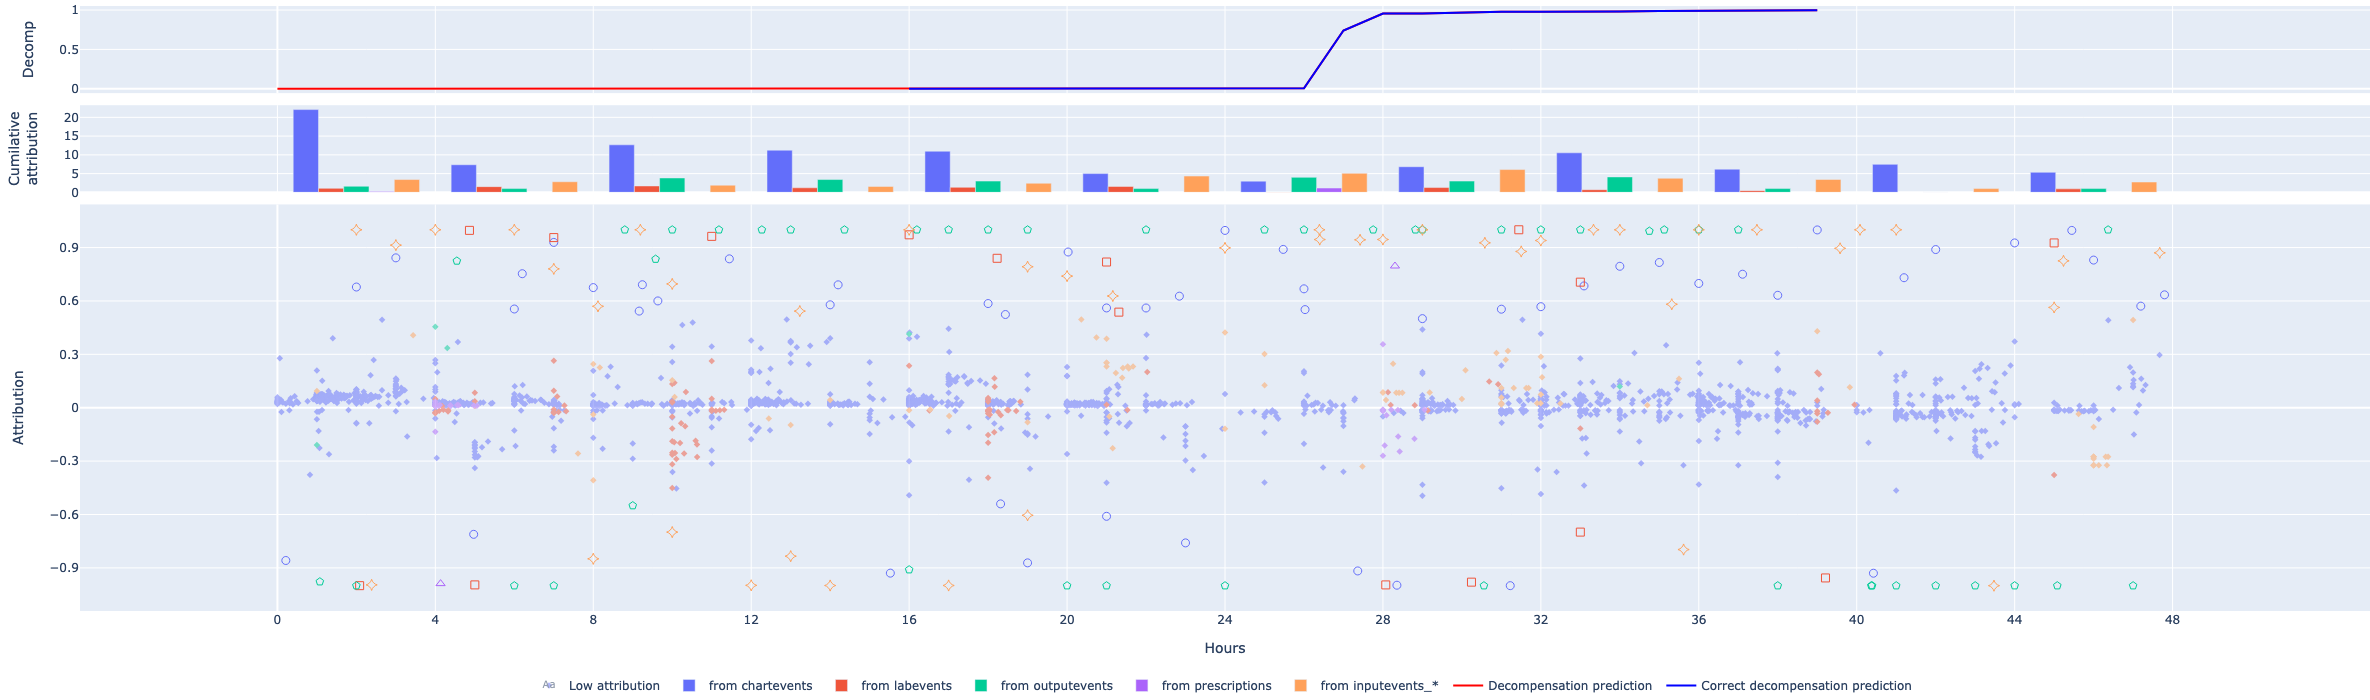

In [30]:
ITER = 300
# STAY = '55136_episode1_timeseries.csv'
# STAY = '89697_episode1_timeseries.csv'
# STAY = '46265_episode1_timeseries.csv'
# STAY = '66825_episode1_timeseries.csv'
# STAY = '12253_episode1_timeseries.csv'
STAY = '45111_episode1_timeseries.csv'
STAY = '88937_episode1_timeseries.csv'
sample = val_set.get_by_filename(STAY)

decomp_pred = decomp_prediction_df.set_index('stay').loc[STAY]
decomp_X = np.zeros((int(decomp_pred['period_length'].max()), 2))
decomp_X[4:, 0] = decomp_prediction_df.set_index('stay').loc[STAY].y_true
decomp_X[4:, 1] = decomp_prediction_df.set_index('stay').loc[STAY].prediction

sample = utils.min_batch([sample], tables, labels, limit=720, event_limit=200)

_, df, _ = create_attribution(sample, n_steps=ITER)
fig = plot_attr_df(df, decomp_X)
fig.write_image(f'notebooks/figures/patient-explanation-{STAY}_iter{ITER}.pdf')
with open(f'patient-explanation-{STAY}_iter{ITER}.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))
fig

# Strategies

In [590]:
X = np.stack(vocab_attrs)[:, 4:]
X.shape

(309, 50350)

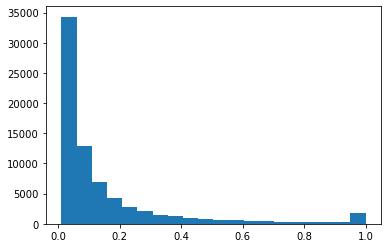

In [591]:
bin_counts, bin_edges, _ = plt.hist(X[X > 0], bins=20)

In [592]:
bin_counts[1:].sum(), bin_edges[1:]

(38912.0,
 array([0.05950128, 0.10900122, 0.15850116, 0.2080011 , 0.25750104,
        0.30700098, 0.35650092, 0.40600085, 0.45550079, 0.50500073,
        0.55450067, 0.60400061, 0.65350055, 0.70300049, 0.75250043,
        0.80200036, 0.8515003 , 0.90100024, 0.95050018, 1.00000012]))

In [593]:
vocab_attr_tokens = np.array(sum([list(t) for t in zip(['!!'+s for s in joint_vocab.itos], ['++'+s for s in joint_vocab.itos])], []))[4:]

def get_top_words(vocab_attr, n_top=None, thres=0):
    sorting = np.argsort(-vocab_attr)
    sorted_attr = vocab_attr[sorting]
    sorted_vocab = vocab_attr_tokens[sorting]
    sorted_vocab = sorted_vocab[sorted_attr > thres]
    return list(sorted_vocab[:n_top])

In [594]:
vocab_attr_tokens

array(['!!calprevflg=1', '++calprevflg=1', '!!Code-Status=Full-Code', ...,
       '++xygris=5', '!!zzz-Stim-Thresh-mA-Value=4',
       '++zzz-Stim-Thresh-mA-Value=4'], dtype='<U157')

In [595]:
from sklearn.feature_extraction.text import TfidfVectorizer
WORD_ACT_THRES = 0
corpus = [
    get_top_words(x, None, 0.595) for x in X
]

def identity_tokenizer(text):
    return text


vectorizer = TfidfVectorizer(lowercase=False,tokenizer=identity_tokenizer, max_df=0.95, min_df=10)
X_tfidf = vectorizer.fit_transform(corpus)
print(X_tfidf.shape)

(309, 65)


In [596]:
# joint_vocab(vocab_attrs)
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, StandardScaler

nmf = NMF(n_components=10, init='nndsvda', random_state=42)

nmf_pipeline = make_pipeline(nmf,
                             StandardScaler())

X_nmf = nmf_pipeline.fit(X_tfidf).transform(X_tfidf)

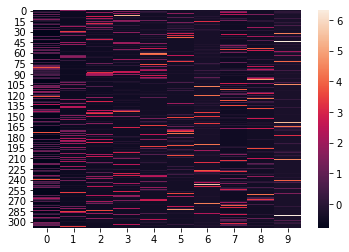

In [597]:
sns.heatmap(X_nmf)

In [598]:
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering

X_embedded = TSNE(n_components=2, perplexity=15, verbose=True, init='pca',
                  random_state=42).fit_transform(X_nmf)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 309 samples in 0.000s...
[t-SNE] Computed neighbors for 309 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 309 / 309
[t-SNE] Mean sigma: 0.712584
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.415585
[t-SNE] KL divergence after 1000 iterations: 0.317757


In [599]:
df = pd.DataFrame(X_embedded, columns=['x', 'y'])
df['stay'] = [pat[0] for pat in pats]
df = df.merge(prediction_df, on='stay')
df = pd.DataFrame(pat_extras).merge(df, left_on='filename', right_on='stay')

In [600]:
n_top = 5
top_words = [get_top_words(attr[4:], n_top) for attr in vocab_attrs]
df_top_words = pd.DataFrame(top_words, columns=[f'top {i}' for i in range(n_top)])
df = pd.concat([df, df_top_words], 1)

In [601]:
for c in labels['phenotyping'].classes:
    df[c] = df['diagnoses'].apply(lambda x: c in x)

In [602]:
def print_top_words(model, feature_names, n_top_words):
    topics = []
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append(f"Topic {topic_idx}")
        top_words_ = ' | '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        top_words.append(top_words_)
    df = pd.DataFrame(topics, columns=['Topic'])
    df['tokens'] = top_words
    return df

In [620]:
with pd.option_context("max_colwidth", 1000):
    print(print_top_words(nmf, vocab_attr_tokens, 10).to_latex(index=False))

with pd.option_context("max_colwidth", 1000):
    with open('notebooks/figures/topic-table.html', 'w') as f:
        f.write(print_top_words(nmf, vocab_attr_tokens, 10).to_html(index=False))

\begin{tabular}{ll}
\toprule
   Topic &                                                                                                                                                                                                                                                      tokens \\
\midrule
 Topic 0 &                        ++Urine-Out-Foley=1 | ++Activity=Bedrest | ++Respiratory-Rate=3 | !!Heart-Rhythm=Normal-Sinus | !!HR-Alarm-High=3 | ++Heart-Rhythm=SR-Sinus-Rhythm | ++.9\%-Normal-Saline=1 | ++Ectopy-Type=None | ++Pain-Present=No | ++Heart-Rate=3 \\
 Topic 1 &             ++Activity-Tolerance=Tolerated-Well | !!Risk-for-Falls=Yes | ++Respiratory-Rate=5 | ++D5W=1 | !!Respiratory-Rate=2 | !!NBP-Alarm-Low=4 | ++Respiratory-Pattern=Regular | ++Urine-Appearance=Clear | ++NBP-Alarm-Low=4 | ++Precautions=Universal \\
 Topic 2 &                                                    !!SpO2-Alarm-High=9 | !!Turn=Side-to-Side | !!Ectopy-Type-1=None | !!Respiratory-Rate=5 | !!SpO2=7 | 

In [604]:
df[['x', 'y']] = X_embedded
df['topic'] = (X_nmf.argmax(-1))

In [605]:
def get_indices(token):
    inds = []
    for ind, key in enumerate(vocab_attr_tokens):
        if token.lower() in key.lower():
            inds.append(ind)
    return inds

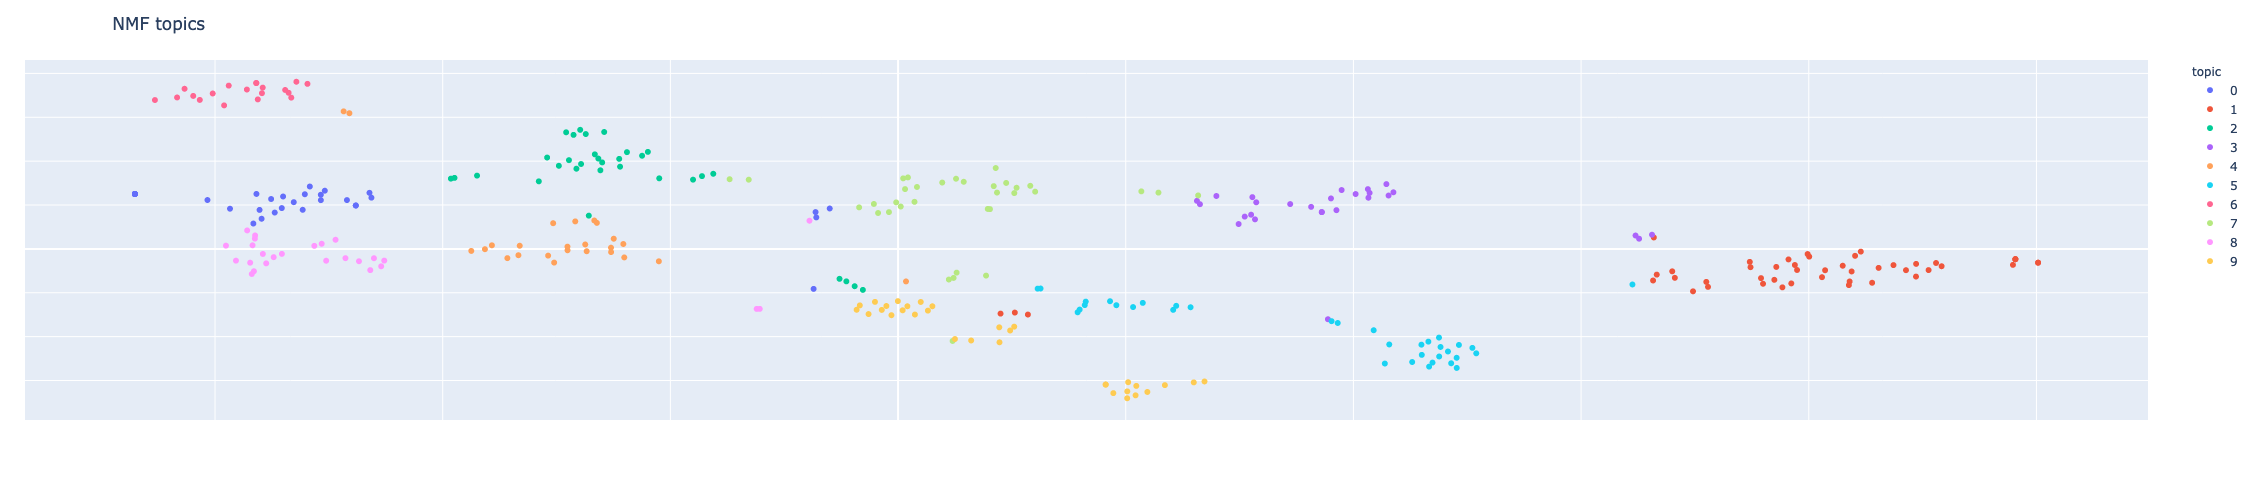

In [606]:
df_topics = df.reset_index()
df_topics = df_topics.sort_values('topic')
df_topics['topic'] = df_topics['topic'].astype(str)
fig = px.scatter(df_topics, x='x', y='y', color='topic', hover_data=['index', 'top 0', 'top 1', 'top 2', 'top 3', 'top 4', 'los', 'topic'], width=900, height=500)

fig.update_layout(title='NMF topics', margin=dict(l=0, r=0), width=370)
fig.update_xaxes(title='', showticklabels=False)
fig.update_yaxes(title='', showticklabels=False)
fig.update_layout(showlegend=True, legend=dict(orientation='v'))
fig.write_image('notebooks/figures/topic.pdf')

with open('notebooks/figures/topic.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))
fig

180


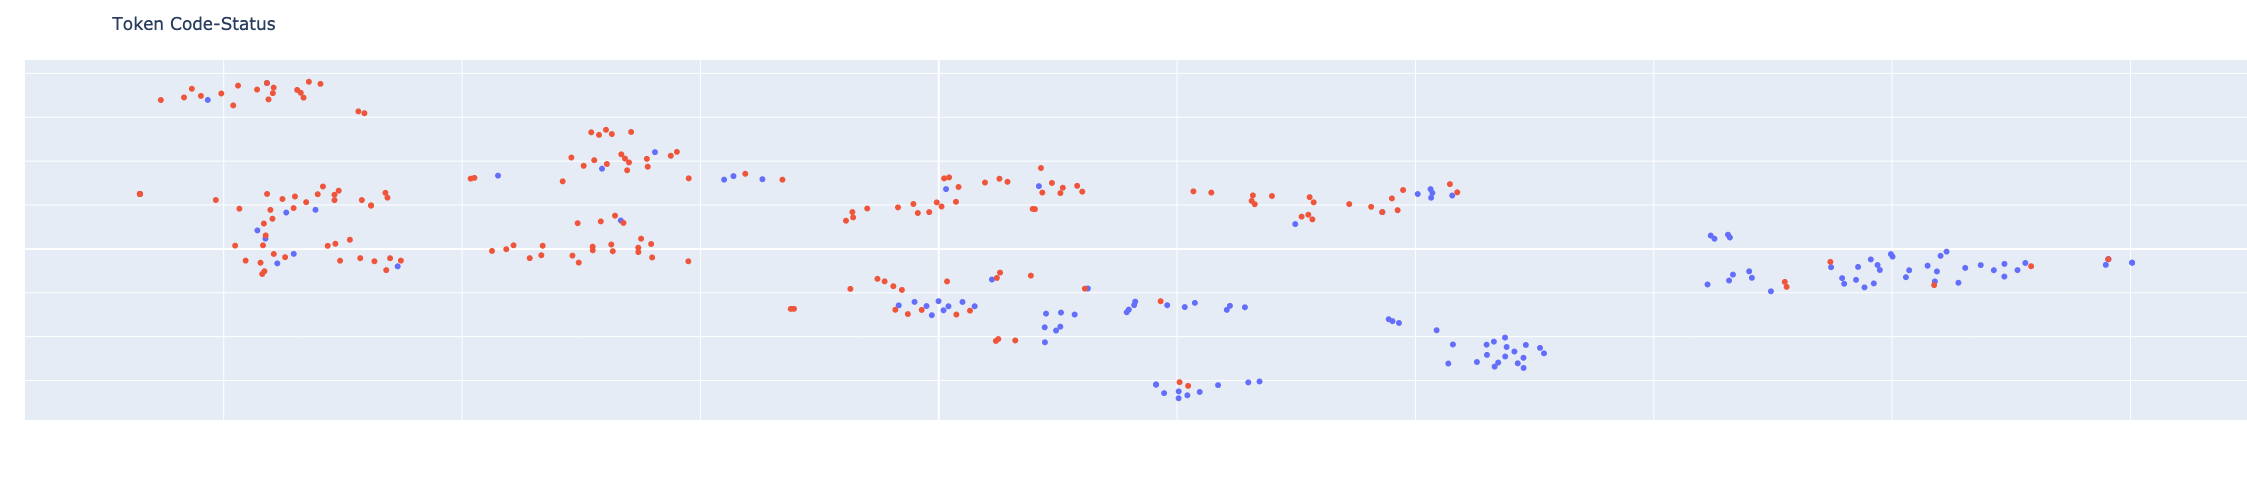

In [607]:
tok = 'Code-Status'

df[tok] = (X[:, get_indices(tok)] > 0).any(-1)
print(df[tok].sum())
fig = px.scatter(df.reset_index().sort_values(tok), x='x', y='y', color=tok, hover_data=['index', 'top 0', 'top 1', 'top 2', 'top 3', 'top 4', 'los', 'topic'], width=600, height=500)

fig.update_layout(title=f'Token {tok}', margin=dict(l=0, r=0), width=300)
fig.update_xaxes(title='', showticklabels=False)
fig.update_yaxes(title='', showticklabels=False)
fig.update_layout(showlegend=False)
fig.write_image(f'notebooks/figures/strategy-token-{tok}.pdf')
fig

In [608]:
#labels['phenotyping'].classes

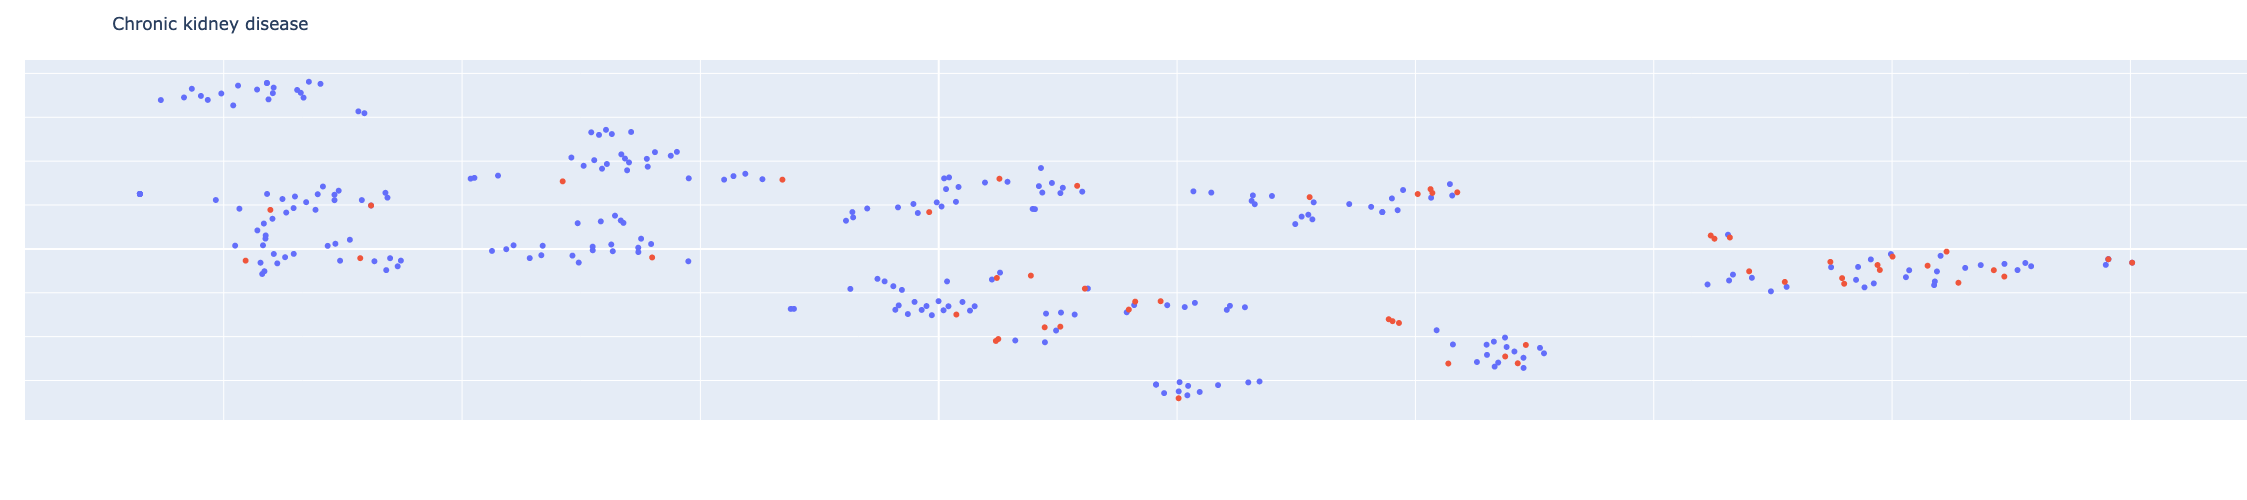

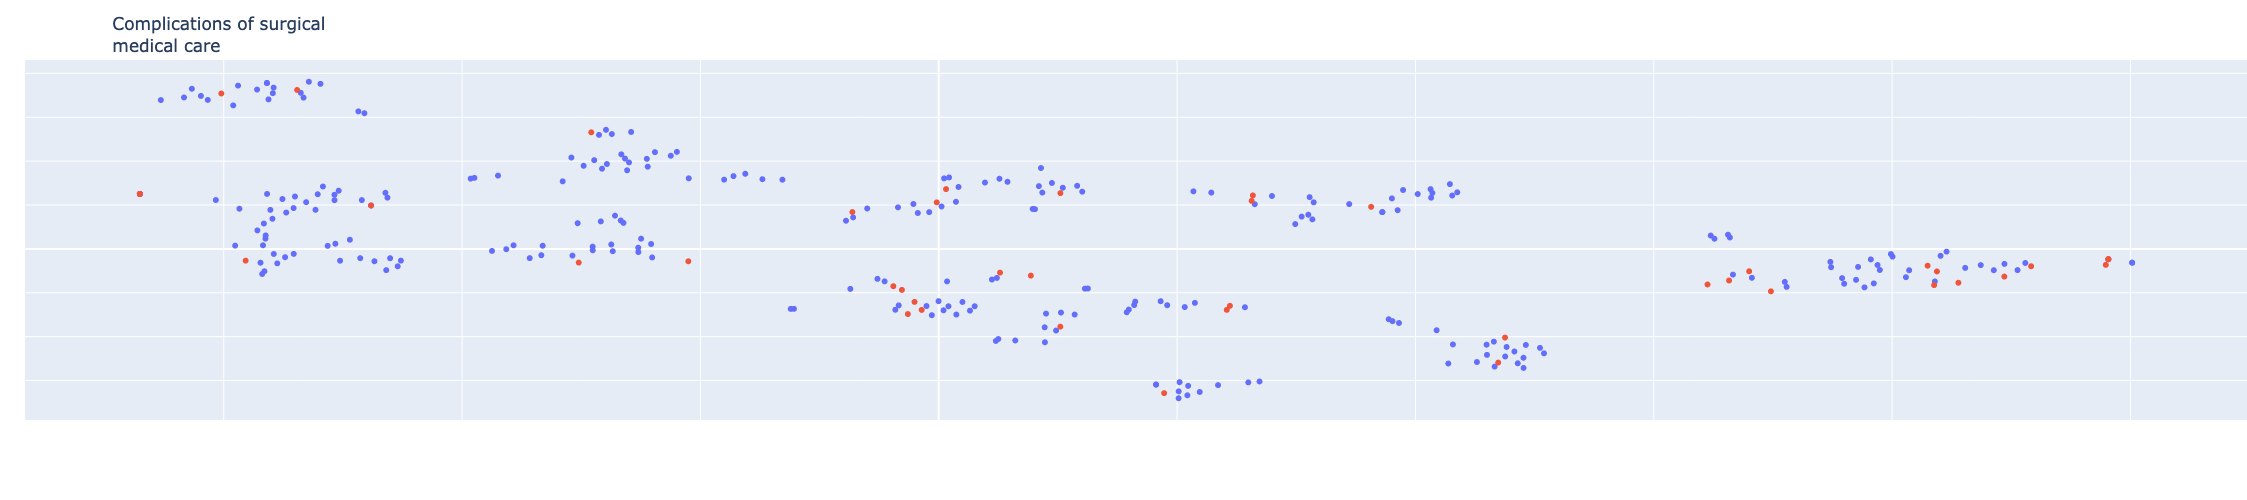

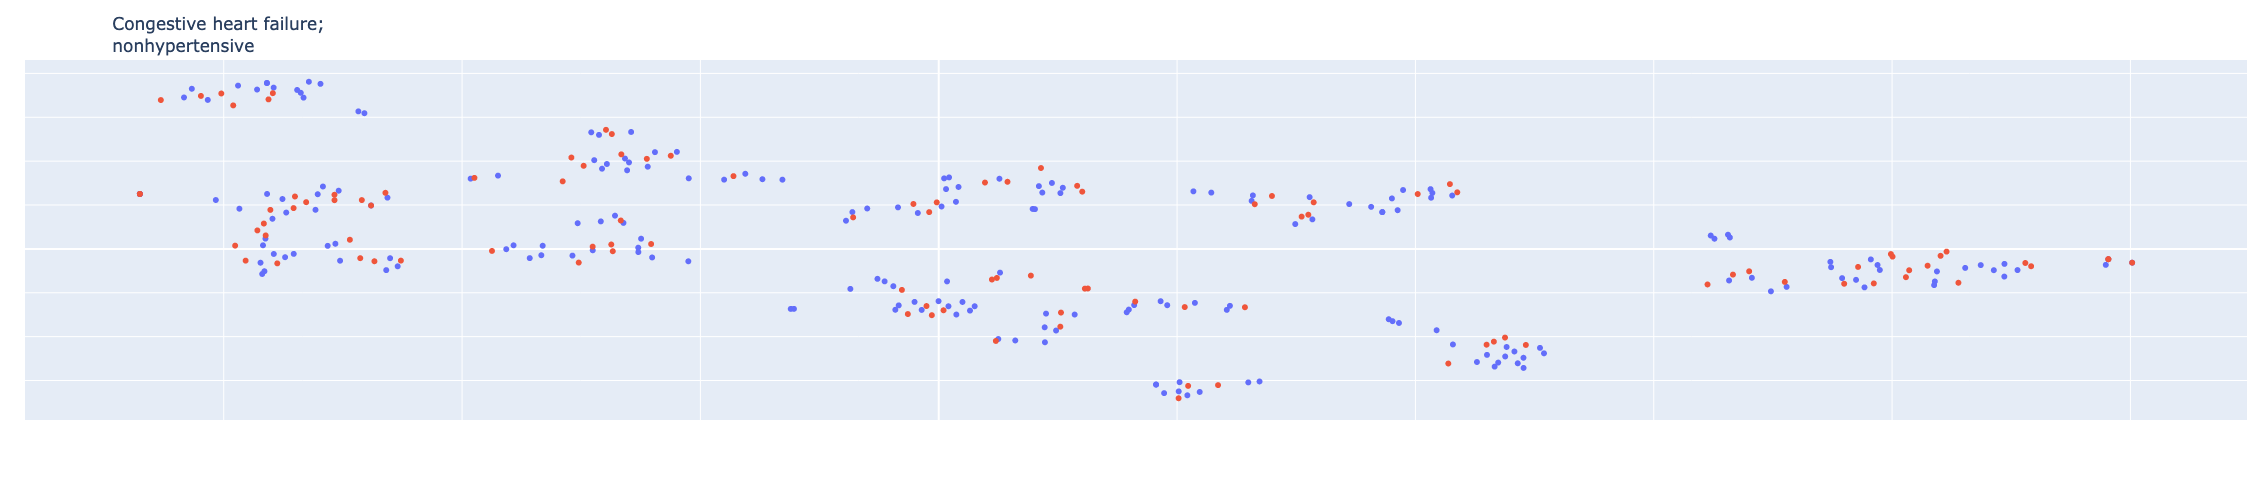

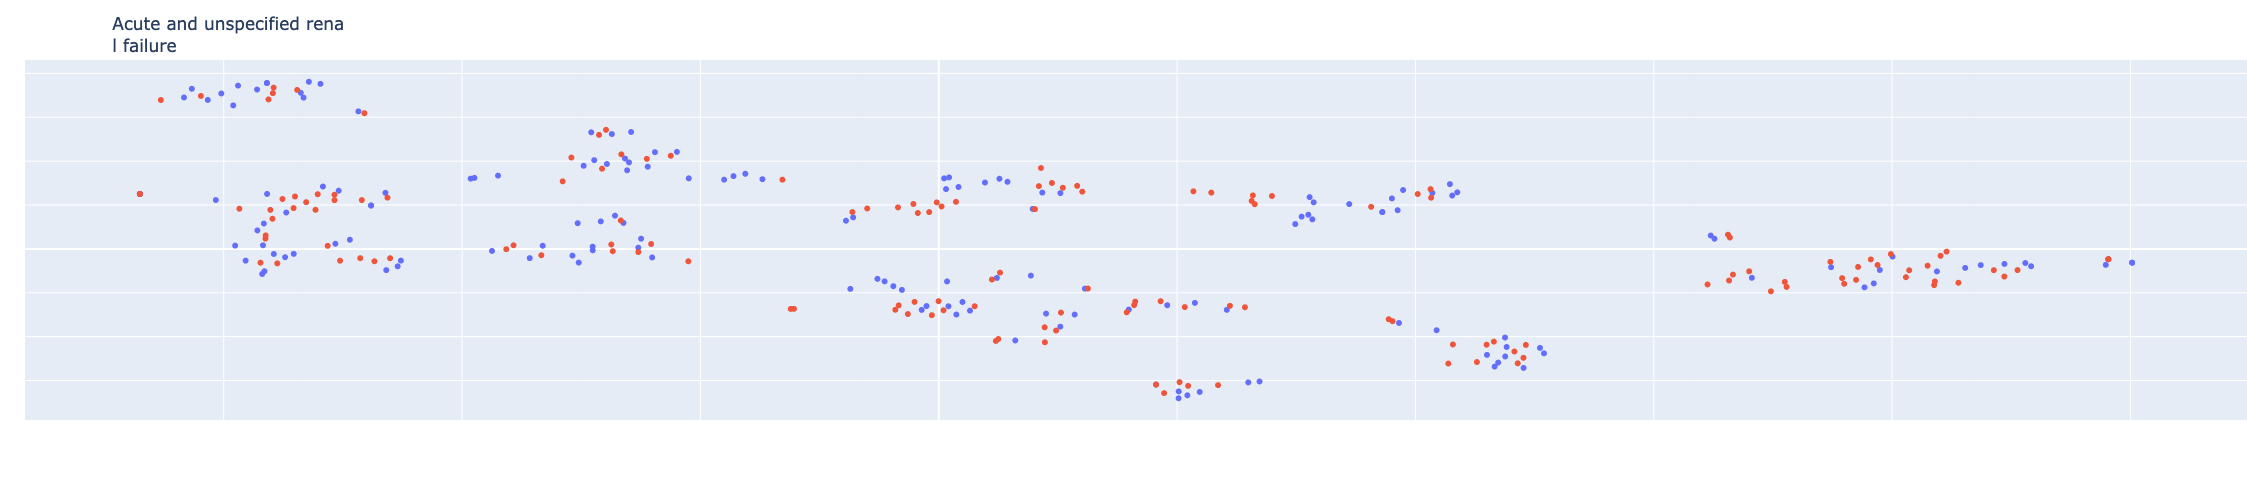

In [617]:
for c in [ 'Chronic kidney disease',  'Complications of surgical/medical care','Congestive heart failure; nonhypertensive', 'Acute and unspecified renal failure']:
# for c in labels['phenotyping'].classes:
    fig = px.scatter(df.reset_index().sort_values(c), x='x', y='y', color=c, hover_data=['index', 'top 0', 'top 1', 'top 2', 'top 3', 'top 4', 'los', 'topic'], width=600, height=500)
    fig.update_layout(title=c.replace('/', ' ')[:26] + '<br>' + c.replace('/', ' ')[26:], margin=dict(l=0, r=0), width=300)
    fig.update_xaxes(title='', showticklabels=False)
    fig.update_yaxes(title='', showticklabels=False)
    fig.update_layout(showlegend=False)
    fig.write_image(f'notebooks/figures/strategy_{c.replace("/", "")}.pdf')

    with open(f'notebooks/figures/strategy_{c.replace("/", "")}.html', 'w') as f:
        f.write(fig.to_html(include_plotlyjs='cdn'))
    fig.show()


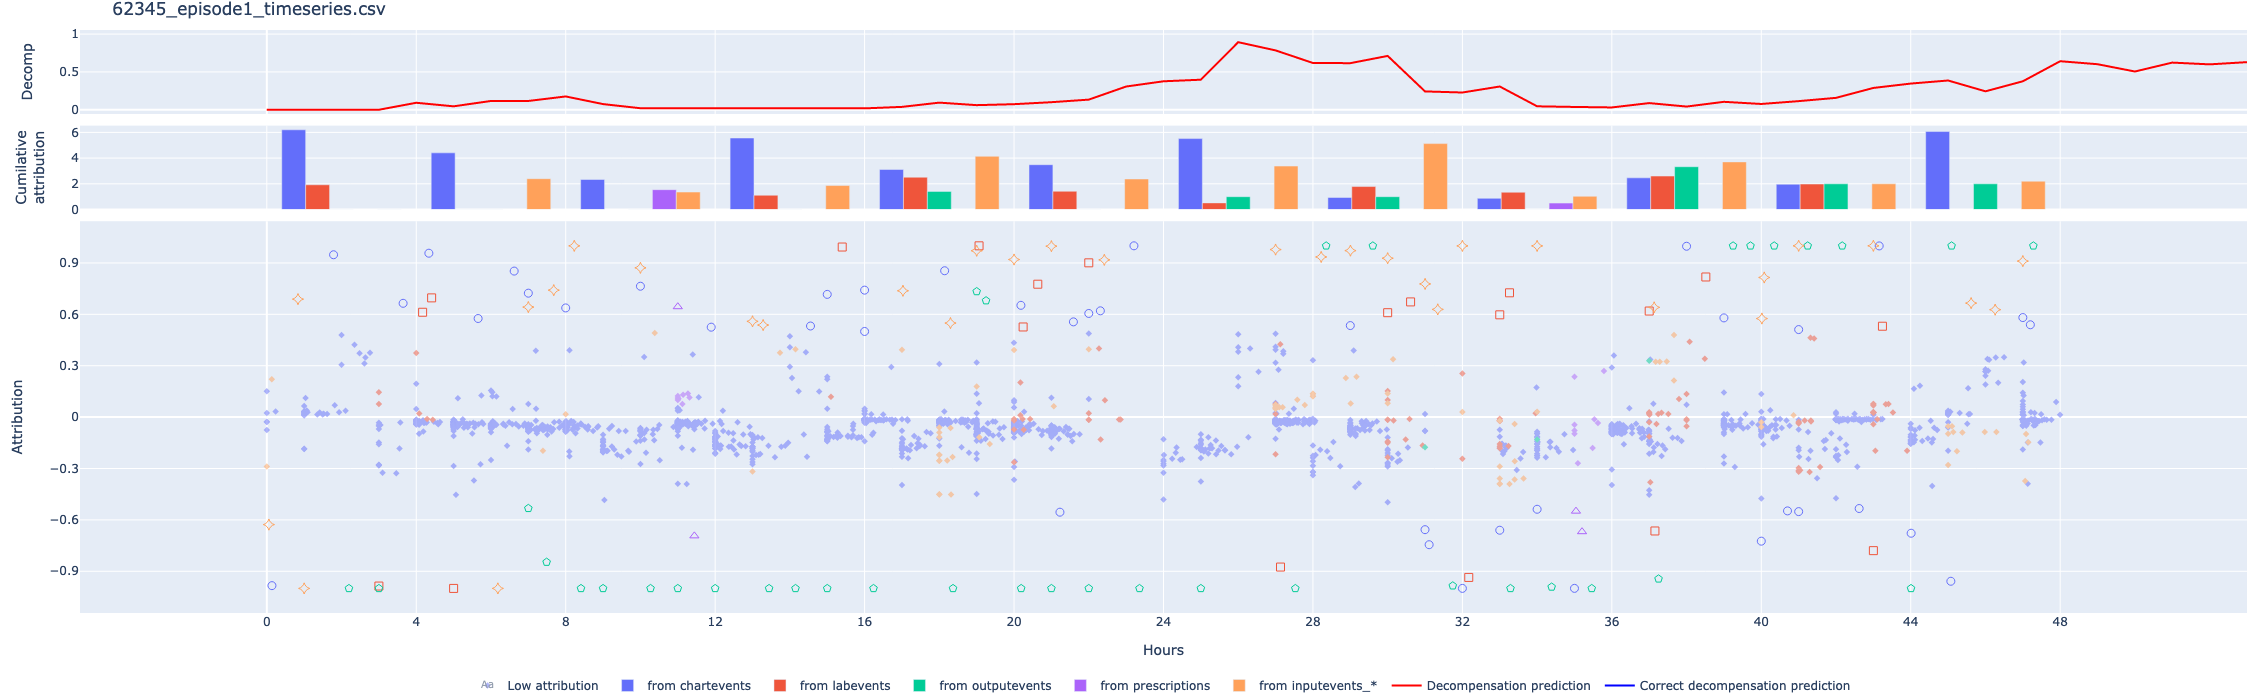

In [610]:
STAY = '62345_episode1_timeseries.csv'
INDEX = sum(pats, []).index(STAY)
decomp_pred = decomp_prediction_df.set_index('stay').loc[STAY]
decomp_X = np.zeros((int(decomp_pred['period_length'].max()), 2))
decomp_X[4:, 0] = decomp_prediction_df.set_index('stay').loc[STAY].y_true
decomp_X[4:, 1] = decomp_prediction_df.set_index('stay').loc[STAY].prediction

fig = plot_attr_df(attribution_dfs[INDEX], decomp_X)
fig.update_layout(title=STAY, margin=dict(t=30))
fig

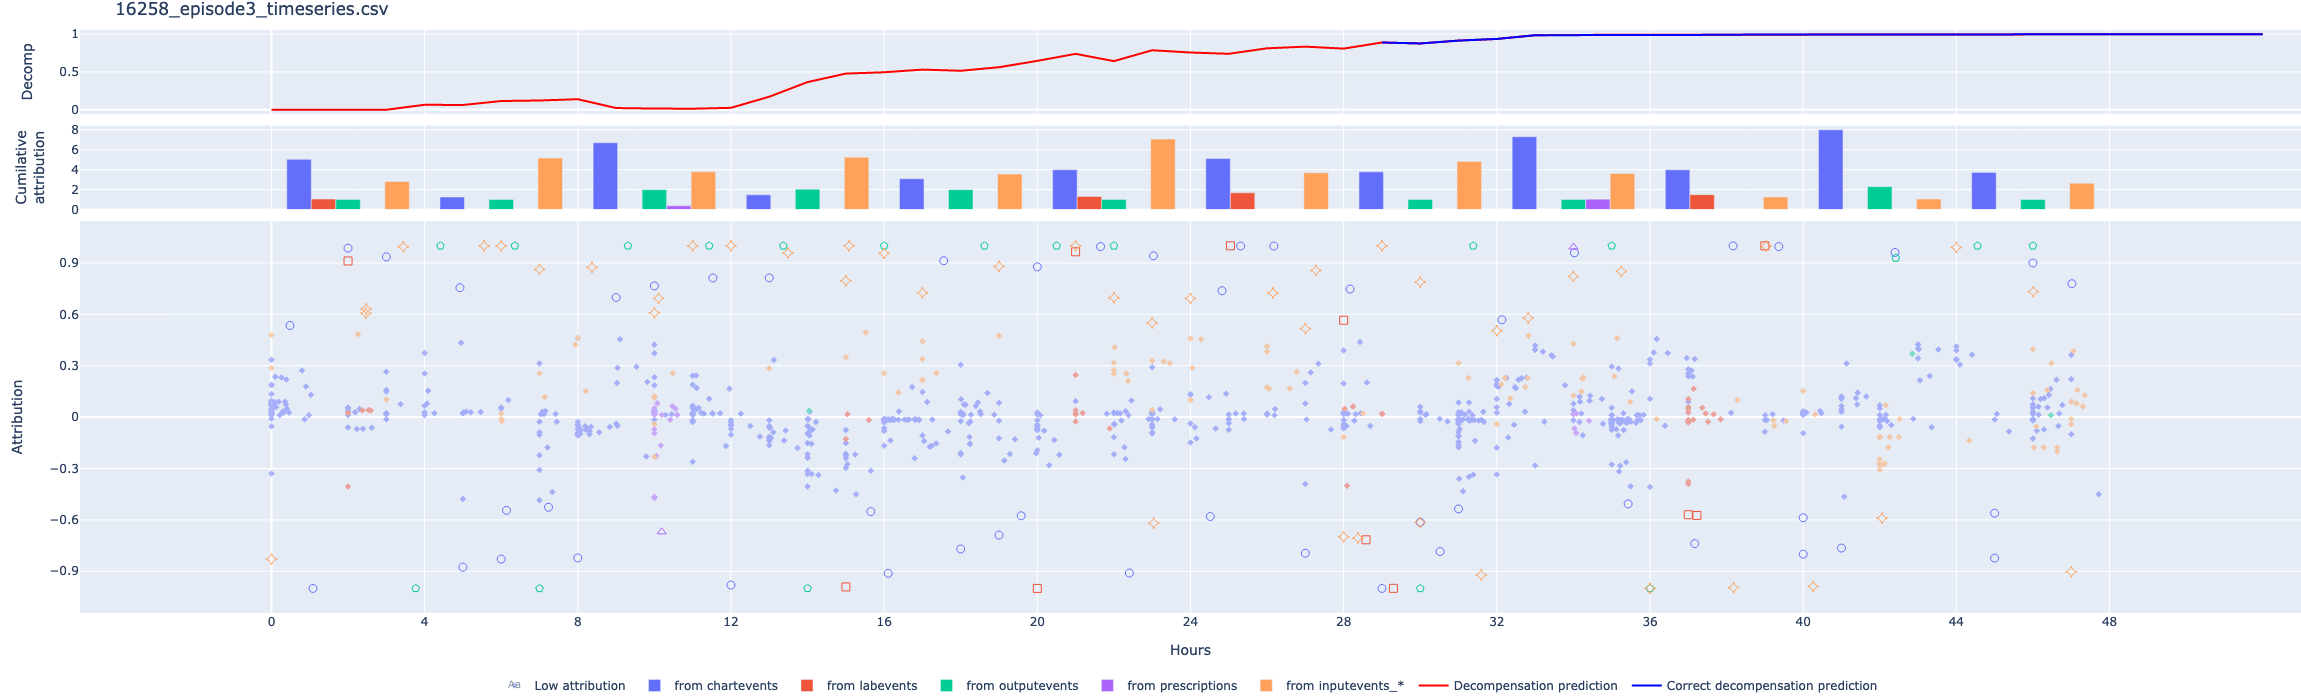

In [90]:
STAY = '16258_episode3_timeseries.csv'
INDEX = sum(pats, []).index(STAY)
decomp_pred = decomp_prediction_df.set_index('stay').loc[STAY]
decomp_X = np.zeros((int(decomp_pred['period_length'].max()), 2))
decomp_X[4:, 0] = decomp_prediction_df.set_index('stay').loc[STAY].y_true
decomp_X[4:, 1] = decomp_prediction_df.set_index('stay').loc[STAY].prediction

fig = plot_attr_df(attribution_dfs[INDEX], decomp_X)
fig.update_layout(title=STAY, margin=dict(t=30))
fig

## Spectral Analysis (Lapuschkin et al. 2019)

In [544]:
group_mask = (['Complications of surgical/medical care' in row.diagnoses for row in df.itertuples()])

In [545]:
X_group = X[group_mask]

In [546]:
len(X_group)

42

In [547]:
from sklearn.feature_extraction.text import TfidfVectorizer
WORD_ACT_THRES = 0
corpus = [
    get_top_words(x, None) for x in X_group
]

def identity_tokenizer(text):
    return text


vectorizer = TfidfVectorizer(lowercase=False,tokenizer=identity_tokenizer, min_df=5, max_df=0.9)
X_tfidf = vectorizer.fit_transform(corpus)
print(X_tfidf.shape)

(42, 576)


In [548]:
from sklearn.cluster import SpectralClustering
# joint_vocab(vocab_attrs)
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, StandardScaler

nmf = NMF(n_components=10, init='nndsvd', random_state=42)

nmf_pipeline = make_pipeline(nmf,
                             StandardScaler())

X_nmf = nmf_pipeline.fit(X_tfidf).transform(X_tfidf)

In [549]:
clustering = SpectralClustering(n_clusters=5,
                                assign_labels="discretize",
                                random_state=42).fit(X_nmf)

In [550]:
W = clustering.affinity_matrix_
D = np.diag(W.sum(-1))
L = D - W

In [551]:
eig_values, eig_vectors = np.linalg.eig(L)

In [552]:
from sklearn.cluster import KMeans, AgglomerativeClustering

kmeans = KMeans(3).fit(eig_vectors.T)

In [553]:
kmeans.labels_

array([0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 0, 1, 2, 2],
      dtype=int32)

In [554]:
eigen_gaps = np.diff(sorted(eig_values)).argsort()[:-6:-1]
eigen_gaps

array([38, 32, 33, 36, 37])

In [573]:
group_df = df.loc[group_mask].reset_index().drop(columns='index').reset_index()
group_df['spectralanalysis'] = clustering.labels_.astype(str)
group_df[['x', 'y']] = TSNE(perplexity=10).fit_transform(clustering.affinity_matrix_)
group_df['eig_values'] = eig_values

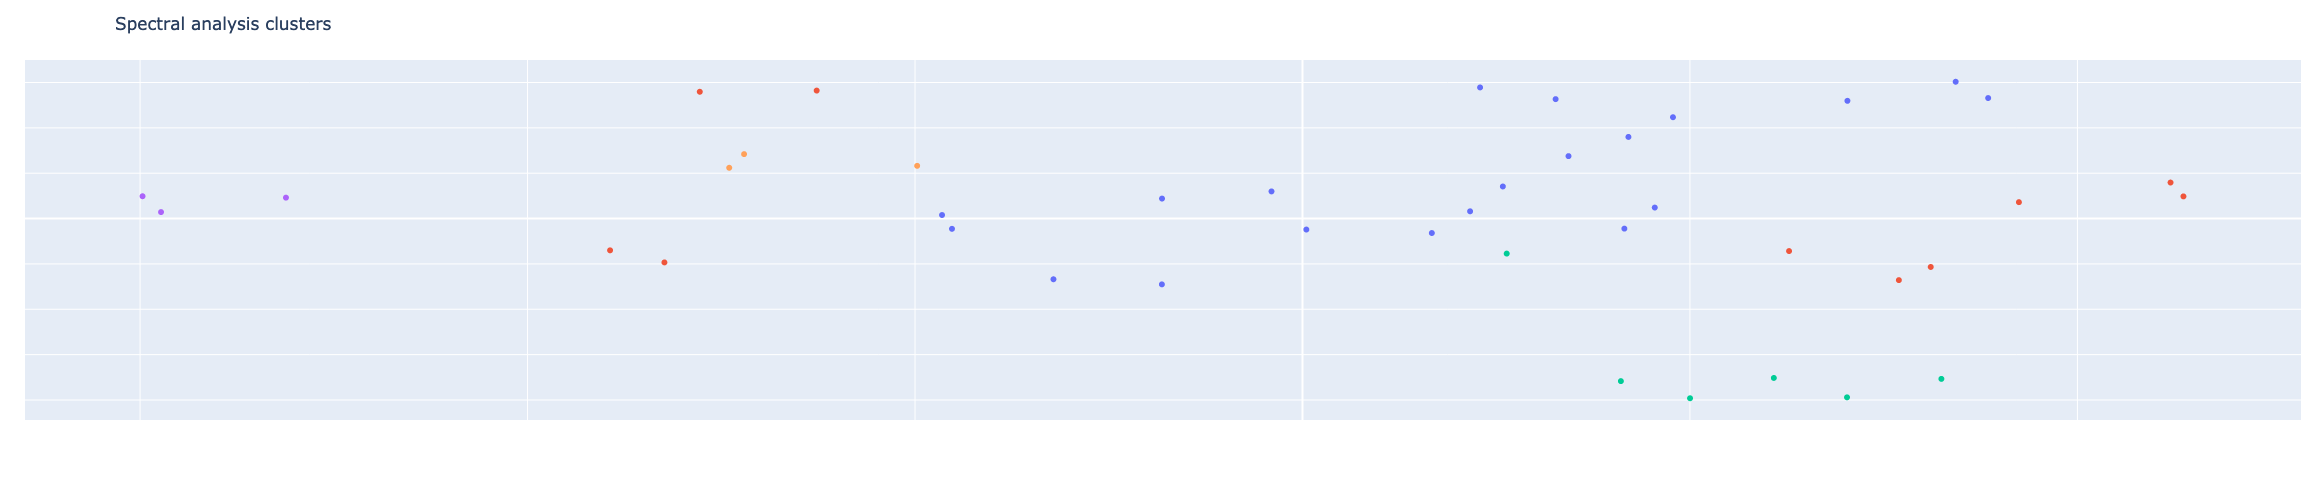

In [575]:
fig = px.scatter(group_df.sort_values('eig_values'), x='x', y='y', color='spectralanalysis', 
                 hover_data=['stay', 'top 0', 'top 1', 'top 2', 'top 3', 'top 4', 'los', 'spectralanalysis', 'index'], width=300, height=500)
fig.update_layout(title='Spectral analysis clusters', margin=dict(l=0, r=0), width=300, height=500)
fig.update_xaxes(title='', showticklabels=False)
fig.update_yaxes(title='', showticklabels=False)
fig.update_layout(showlegend=False)
fig.write_image('notebooks/figures/spectralanalysis-clusters.pdf')

fig

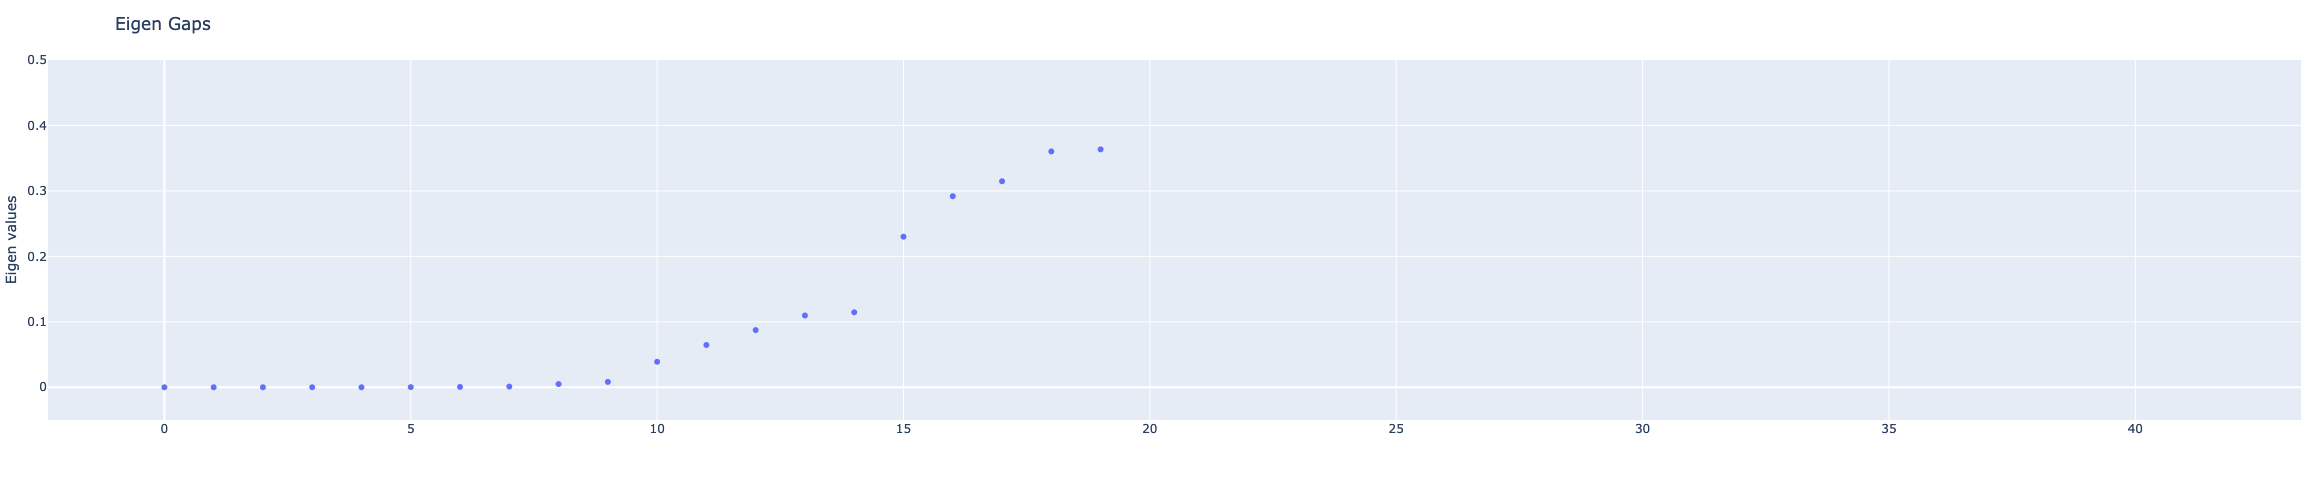

In [582]:
fig = px.scatter(group_df.sort_values('eig_values'), x=np.arange(len(group_df)), y='eig_values', 
                 hover_data=['stay', 'index'],)
# for jump in eigen_gaps:
#     fig.add_shape(type='line',
#               yref="y",
#               xref="x",
#               x0=jump+.5,
#               y0=0,
#               x1=jump+.5,
#               y1=eig_values.max()*1.2,
#               line=dict(color='black', width=1.5))
    
    
fig.update_layout(title='Eigen Gaps', margin=dict(l=0, r=0), width=300, height=500)
fig.update_xaxes(title='')
fig.update_yaxes(title='Eigen values', range=[-0.05, 0.5])
fig.update_layout(showlegend=False)
fig.write_image('notebooks/figures/spectralanalysis-eigengaps.pdf')
    
fig

In [583]:
group_df.iloc[[14,33]]

index       los   subj   episode    idx                       filename  \
14     14   57.1920  21866  episode2  14352  21866_episode2_timeseries.csv   
33     33  221.8056  52666  episode1   1495  52666_episode1_timeseries.csv   

    Ethnicity  Gender        Age  Height  ...  Pneumonia  \
14        4.0     1.0  88.539065   165.0  ...      False   
33        4.0     1.0  70.732500   155.0  ...      False   

   Respiratory failure; insufficiency; arrest  Septicemia (except in labor)  \
14                                       True                          True   
33                                       True                         False   

    Shock topic  Morphine-Sulfate  Fentanyl Code-Status spectralanalysis  \
14  False     9              True     False       False                4   
33  False     1             False     False        True                4   

   eig_values  
14   1.250389  
33   0.004923  

[2 rows x 53 columns]

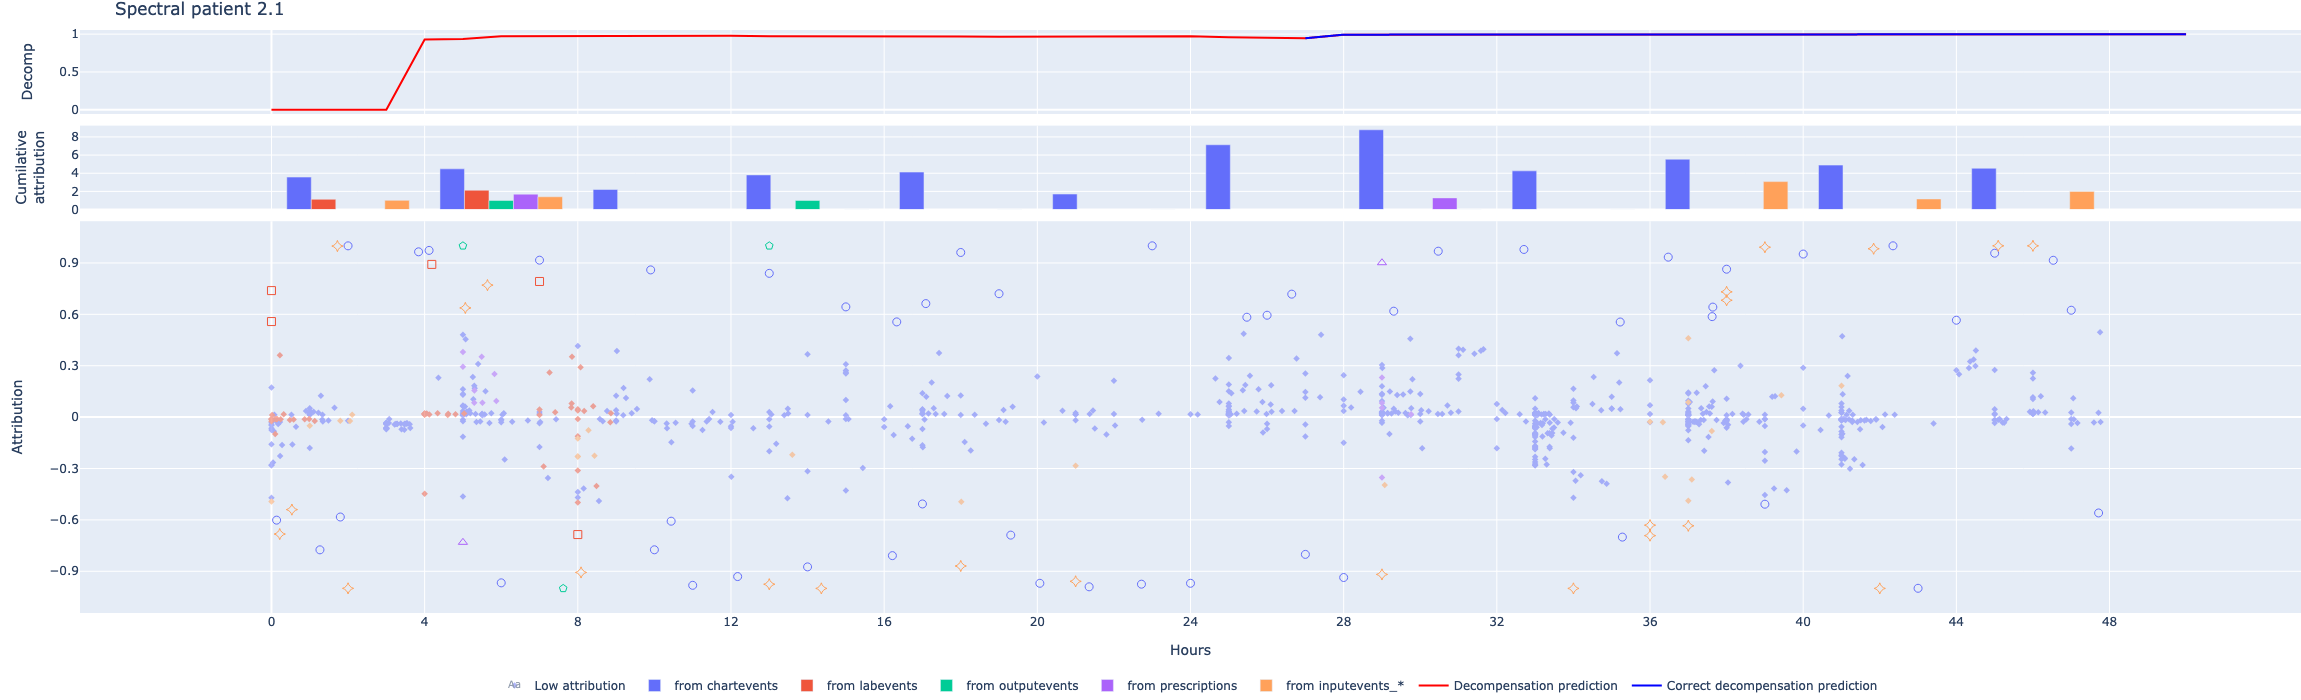

In [584]:
STAY = '21866_episode2_timeseries.csv'
INDEX = sum(pats, []).index(STAY)
decomp_pred = decomp_prediction_df.set_index('stay').loc[STAY]
decomp_X = np.zeros((int(decomp_pred['period_length'].max()), 2))
decomp_X[4:, 0] = decomp_prediction_df.set_index('stay').loc[STAY].y_true
decomp_X[4:, 1] = decomp_prediction_df.set_index('stay').loc[STAY].prediction

fig = plot_attr_df(attribution_dfs[INDEX], decomp_X)
fig.update_layout(title='Spectral patient 2.1', margin=dict(t=30))

with open('notebooks/figures/spectral-pat-2-1.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))
fig

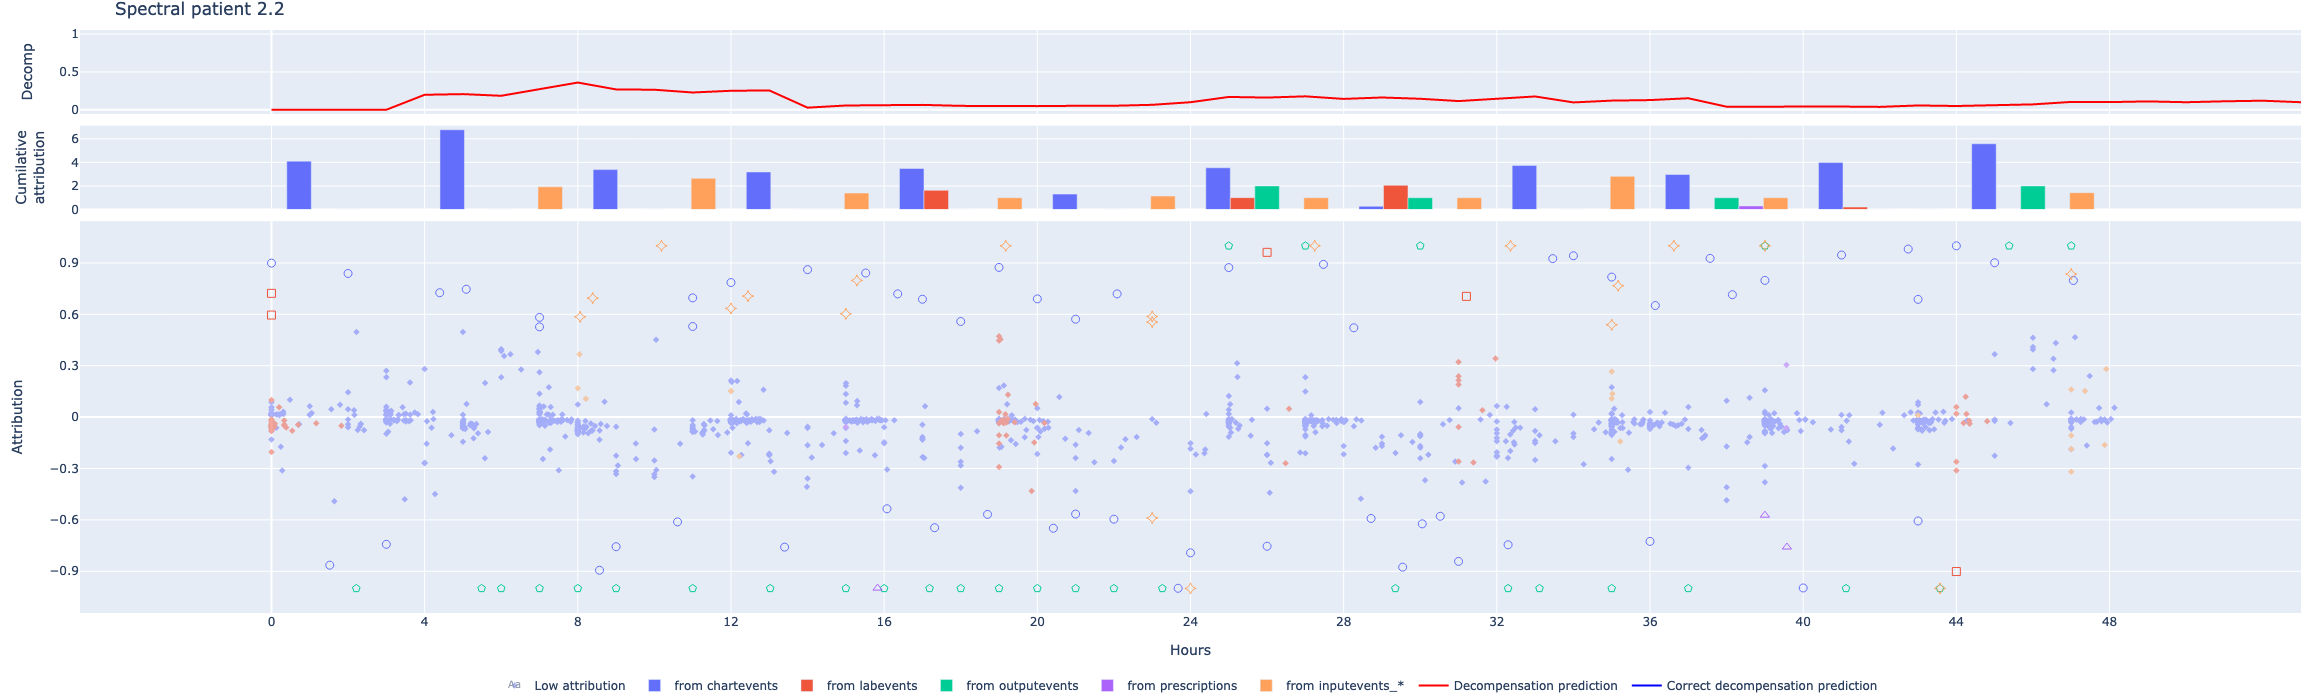

In [585]:
STAY = '52666_episode1_timeseries.csv'
INDEX = sum(pats, []).index(STAY)
decomp_pred = decomp_prediction_df.set_index('stay').loc[STAY]
decomp_X = np.zeros((int(decomp_pred['period_length'].max()), 2))
decomp_X[4:, 0] = decomp_prediction_df.set_index('stay').loc[STAY].y_true
decomp_X[4:, 1] = decomp_prediction_df.set_index('stay').loc[STAY].prediction

fig = plot_attr_df(attribution_dfs[INDEX], decomp_X)
fig.update_layout(title='Spectral patient 2.2', margin=dict(t=30))

with open('notebooks/figures/spectral-pat-2-2.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))
fig

In [586]:
group_df.iloc[[2,12,29]]

index       los   subj   episode    idx                       filename  \
2       2  130.0848  53192  episode1    918  53192_episode1_timeseries.csv   
12     12  102.1752  42049  episode1  10505  42049_episode1_timeseries.csv   
29     29   51.9312  86927  episode1  32946  86927_episode1_timeseries.csv   

    Ethnicity  Gender        Age  Height  ...  Pneumonia  \
2         0.0     1.0  78.937482     NaN  ...      False   
12        4.0     2.0  68.794161   178.0  ...      False   
29        4.0     1.0  79.517400   155.0  ...      False   

   Respiratory failure; insufficiency; arrest  Septicemia (except in labor)  \
2                                       False                         False   
12                                      False                         False   
29                                      False                         False   

    Shock topic  Morphine-Sulfate  Fentanyl Code-Status spectralanalysis  \
2   False     1             False      True       False                2   
12  False     5             False     False       False                2   
29  False     1             False      True       False                2   

   eig_values  
2    3.812094  
12   1.447716  
29   0.087338  

[3 rows x 53 columns]

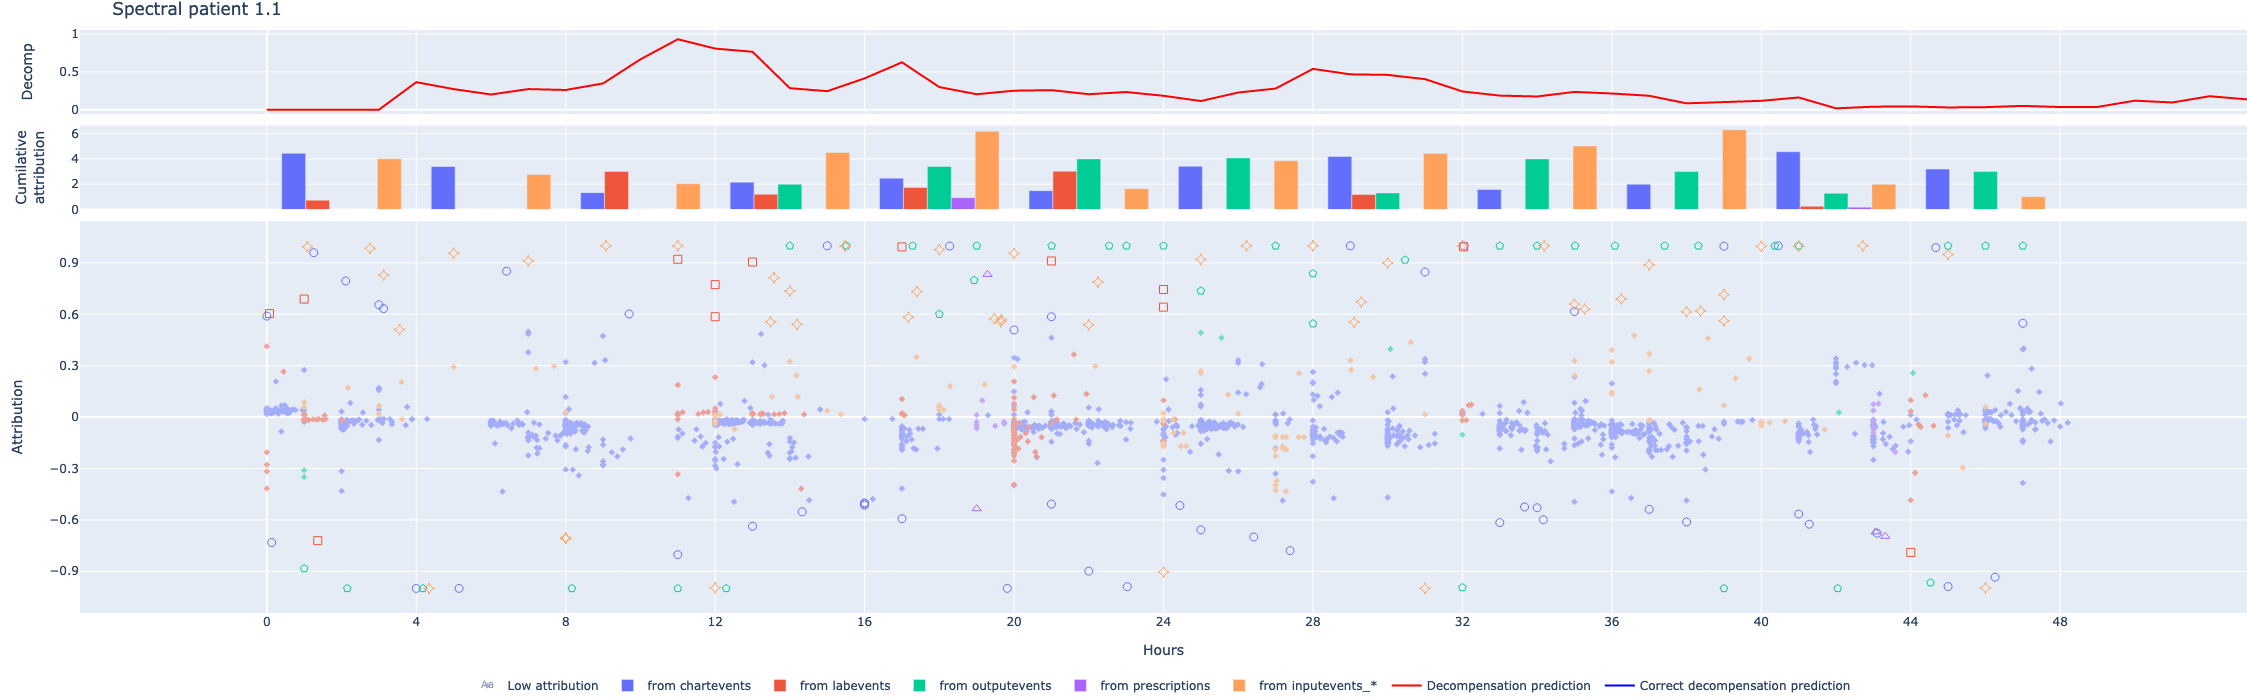

In [589]:
STAY = '53192_episode1_timeseries.csv'
INDEX = sum(pats, []).index(STAY)
decomp_pred = decomp_prediction_df.set_index('stay').loc[STAY]
decomp_X = np.zeros((int(decomp_pred['period_length'].max()), 2))
decomp_X[4:, 0] = decomp_prediction_df.set_index('stay').loc[STAY].y_true
decomp_X[4:, 1] = decomp_prediction_df.set_index('stay').loc[STAY].prediction

fig = plot_attr_df(attribution_dfs[INDEX], decomp_X)
fig.update_layout(title='Spectral patient 1.1', margin=dict(t=30))

with open('notebooks/figures/spectral-pat-1-1.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))
fig

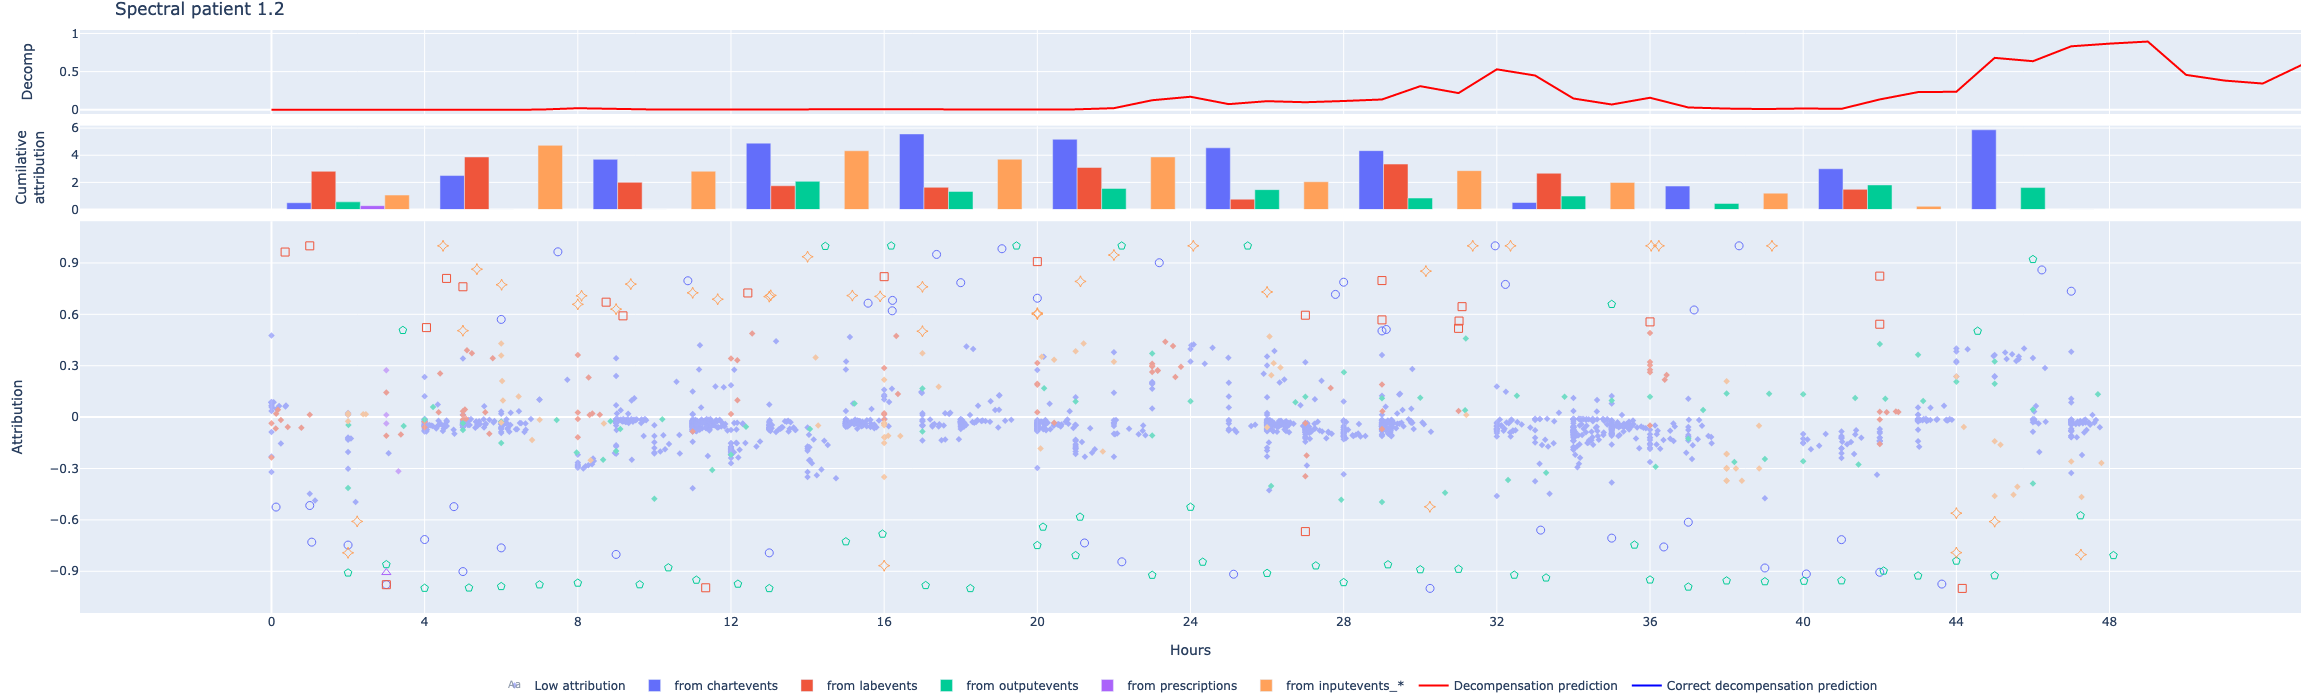

In [587]:
STAY = '42049_episode1_timeseries.csv'
INDEX = sum(pats, []).index(STAY)
decomp_pred = decomp_prediction_df.set_index('stay').loc[STAY]
decomp_X = np.zeros((int(decomp_pred['period_length'].max()), 2))
decomp_X[4:, 0] = decomp_prediction_df.set_index('stay').loc[STAY].y_true
decomp_X[4:, 1] = decomp_prediction_df.set_index('stay').loc[STAY].prediction

fig = plot_attr_df(attribution_dfs[INDEX], decomp_X)
fig.update_layout(title='Spectral patient 1.2', margin=dict(t=30))

with open('notebooks/figures/spectral-pat-1-2.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))
fig

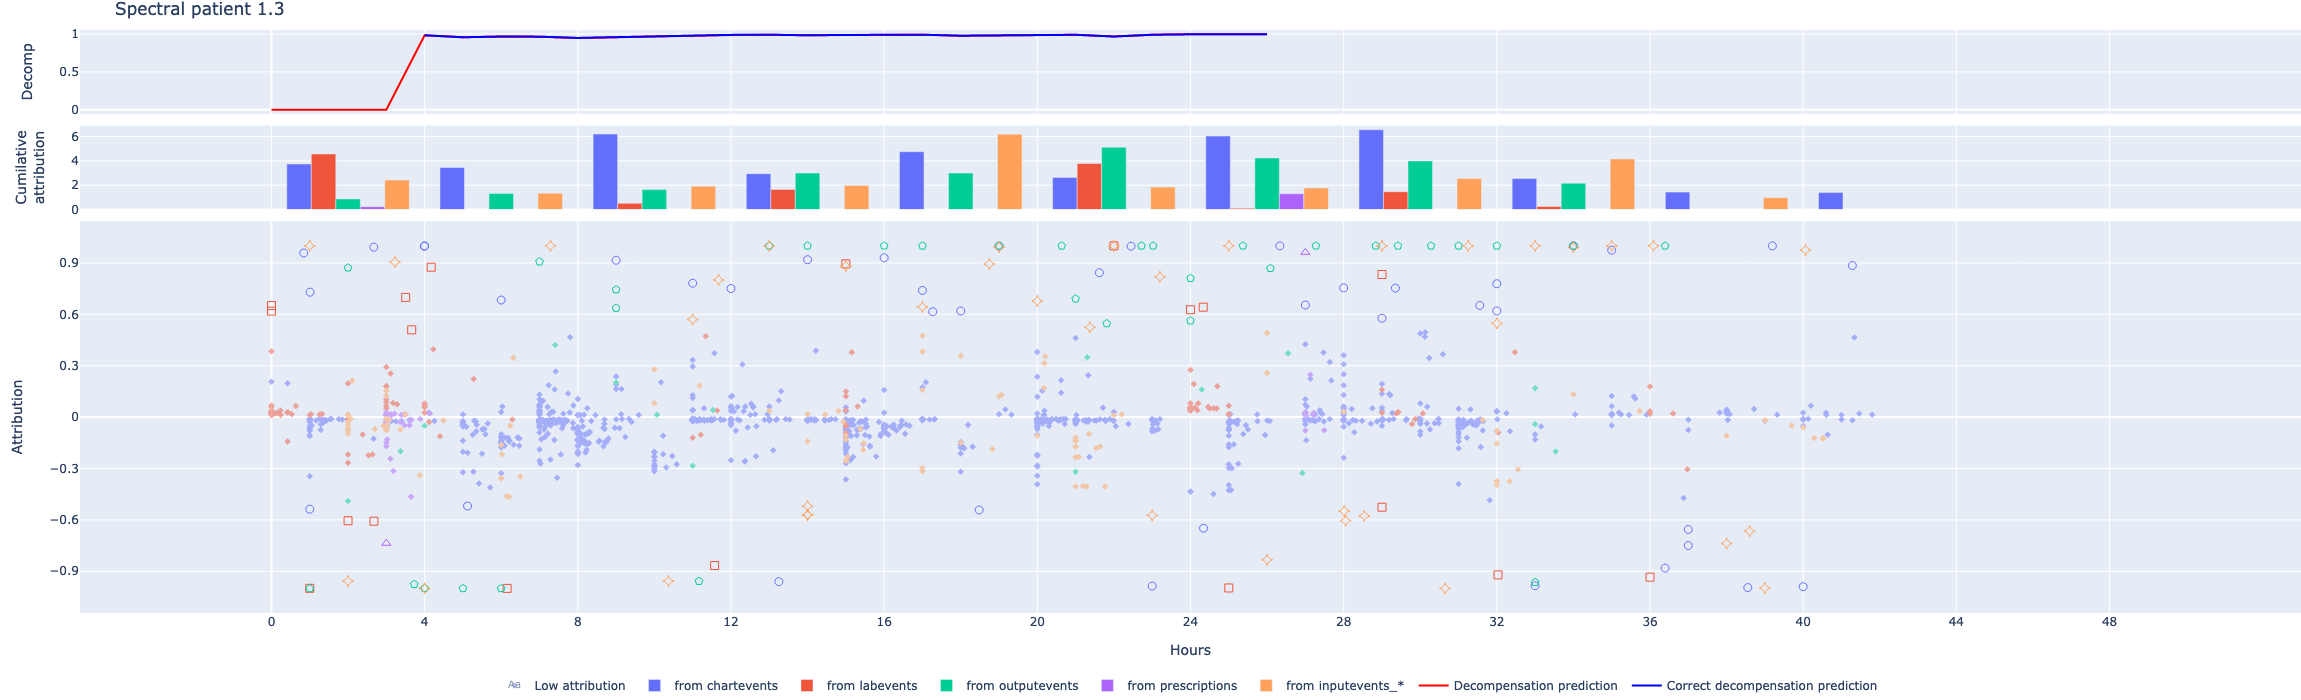

In [588]:
STAY = '86927_episode1_timeseries.csv'
INDEX = sum(pats, []).index(STAY)
decomp_pred = decomp_prediction_df.set_index('stay').loc[STAY]
decomp_X = np.zeros((int(decomp_pred['period_length'].max()), 2))
decomp_X[4:, 0] = decomp_prediction_df.set_index('stay').loc[STAY].y_true
decomp_X[4:, 1] = decomp_prediction_df.set_index('stay').loc[STAY].prediction

fig = plot_attr_df(attribution_dfs[INDEX], decomp_X)
fig.update_layout(title='Spectral patient 1.3', margin=dict(t=30))

with open('notebooks/figures/spectral-pat-1-3.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))
fig

# Plot most attributions

In [61]:
len(attribution_dfs), len(correct_predictions)

(330, 347)

In [62]:
most_attributions_df = pd.concat(attribution_dfs, axis=0)
most_attributions_df.to_csv(f'notebooks/integ_iter{ITER}_grad_attributions.tsv', sep='\t', index=False)
# most_attributions_df = pd.read_csv(f'notebooks/integ_iter{ITER}_grad_attributions.tsv', sep='\t')

In [63]:
len(most_attributions_df)

526726

In [64]:
most_attributions_summary_df = most_attributions_df[['token', 'attribution', 'feature']]
most_attributions_summary_df = most_attributions_summary_df.groupby(['token', 'feature']).agg(['median','mean', 'var', 'sum', 'count'])
most_attributions_summary_df = most_attributions_summary_df.dropna()
most_attributions_summary_df = most_attributions_summary_df[most_attributions_summary_df[('attribution', 'count')] > 10]
most_attributions_summary_df = most_attributions_summary_df.sort_values(('attribution', 'mean')).reset_index()

In [65]:
most_attributions_summary_df['freqs'] = most_attributions_summary_df['token'].apply(lambda x: joint_vocab.freqs[x])

In [66]:
pd.set_option("display.max_rows", 40)
pd.set_option("display.min_rows", 20)

In [67]:
most_attributions_summary_df.columns = ['token', 'feature', 'median', 'mean', 'var', 'sum', 'count', 'freqs']

In [68]:
most_attributions_summary_df[most_attributions_summary_df['token'].str.startswith('Heart')].sort_values('mean')

token      feature    median  \
156                          Heart-Rhythm=Junctional  chartevents -0.145325   
297   Heart-Rhythm=SVT-Supra-Ventricular-Tachycardia  chartevents -0.220654   
358                             Heart-Rhythm=A-Paced  chartevents -0.041780   
543                    Heart-Rhythm=1st-Deg-AV-Block  chartevents -0.069520   
584                                     Heart-Rate=1  chartevents -0.049572   
598        Heart-Rhythm=1st-AV-First-degree-AV-Block  chartevents -0.065527   
1084                                    Heart-Rate=2  chartevents -0.035807   
1153                    Heart-Rhythm=SR-Sinus-Rhythm  chartevents -0.039148   
1186             Heart-Rhythm=AF-Atrial-Fibrillation  chartevents -0.044327   
1202                Heart-Rhythm=SA-Sinus-Arrhythmia  chartevents -0.029489   
1240                                    Heart-Rate=4  chartevents -0.032692   
1326                                    Heart-Rate=3  chartevents -0.032927   
1392                        Heart-Rhythm=Sinus-Brady  chartevents -0.027565   
1685                         Heart-rate-Alarm-High=3  chartevents -0.026493   
1761               Heart-Rhythm=SB-Sinus-Bradycardia  chartevents -0.027778   
1817                          Heart-Rate-Alarm-Low=4  chartevents -0.023290   
1829                                    Heart-Rate=5  chartevents -0.029495   
2187                         Heart-rate-Alarm-High=5  chartevents -0.028219   
2299                       Heart-Rhythm=Normal-Sinus  chartevents -0.025070   
2340                                    Heart-Rate=9  chartevents -0.026352   
2572                        Heart-Rhythm=Sinus-Tachy  chartevents -0.020183   
2625               Heart-Rhythm=ST-Sinus-Tachycardia  chartevents -0.022686   
2656                          Heart-Rate-Alarm-Low=9  chartevents -0.020527   
2666                                    Heart-Rate=6  chartevents -0.018754   
2685                           Heart-Rhythm=AV-Paced  chartevents -0.025813   
2813                    Heart-Rhythm=Supravent-Tachy  chartevents -0.046280   
2878               Heart-Rhythm=JR-Junctional-Rhythm  chartevents -0.066999   
2967                         Heart-Rhythm=Atrial-Fib  chartevents -0.013095   
2985                     Heart-Rhythm=Atrial-Flutter  chartevents -0.021945   
3053                   Heart-Rhythm=Sinus-Arrhythmia  chartevents -0.030770   
3672                            Heart-Rhythm=V-Paced  chartevents -0.023879   
3692                                    Heart-Rate=8  chartevents  0.028474   
3740                                    Heart-Rate=7  chartevents  0.014237   
3960                                    Heart-Rate=0  chartevents  0.058608   

          mean       var        sum  count    freqs  
156  -0.227281  0.097984  -5.227459     23     4255  
297  -0.139420  0.158566  -2.091301     15     1319  
358  -0.115447  0.122828 -11.890998    103    39881  
543  -0.079280  0.016092 -17.203767    217    29763  
584  -0.073780  0.028571 -52.900518    717   179951  
598  -0.072850  0.042732  -3.496803     48    23213  
1084 -0.047895  0.028609 -53.162970   1110   432512  
1153 -0.046112  0.025189 -65.709185   1425   695972  
1186 -0.045061  0.032062 -12.436872    276   129647  
1202 -0.044675  0.004015  -0.491427     11     2134  
1240 -0.043892  0.017761 -96.606183   2201   702314  
1326 -0.041953  0.025306 -70.313747   1676   633079  
1392 -0.040282  0.054637  -4.914398    122    58745  
1685 -0.034379  0.002413  -4.262949    124   102748  
1761 -0.032683  0.022280  -5.752126    176    45275  
1817 -0.031253  0.001685  -3.875383    124    73380  
1829 -0.031074  0.012754 -47.481449   1528   476317  
2187 -0.024376  0.001990  -0.341268     14     8869  
2299 -0.022224  0.015142 -58.493608   2632  1006794  
2340 -0.021132  0.216289  -7.142494    338    24384  
2572 -0.015542  0.006888 -16.801165   1081   260672  
2625 -0.014131  0.024464  -9.933786    703   185173  
2656 -0.012741  0.004287  -0.522392    

In [69]:
df = most_attributions_summary_df.iloc[most_attributions_summary_df.groupby(['feature'])['mean'].nlargest(7).reset_index(0).index]
df['feature'] = df['feature'].str.upper()
df = df.sort_values('mean').set_index(['feature','token']).sort_index()
df

/home/oserbetci/miniconda/envs/icu/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



median      mean  \
feature       token                                                        
CHARTEVENTS   Code-Status=Comfort-Measures            0.987557  0.871029   
              Code-Status=DNR-/-DNI                   0.536295  0.578120   
              Family-Communication=Family-Conferenc   0.995512  0.769834   
              Family-Communication=Family-Conference  0.888199  0.655107   
              Spiritual-Support=Clergy-Notified       0.985108  0.862696   
              Spiritual-Support=Clergy-Visited        0.926780  0.624215   
              Vision-Mask=Face                        0.659887  0.552485   
INPUTEVENTS_* 3%-Normal-Saline=2                      0.863009  0.696884   
              Nitroprusside=5                         0.812505  0.738003   
              Nitroprusside=7                         0.878539  0.761542   
              PO-Intake=1                             1.000000  0.666496   
              PO-Intake=3                             1.000000  0.649743   
              Platelets=5                             0.894924  0.655656   
              TPN-w/Lipids=6                          0.844667  0.740802   
LABEVENTS     Lactate=5                               0.718797  0.566179   
              Osmolality,-Urine=3                     0.876124  0.713419   
              Osmolality,-Urine=4                     0.831930  0.705940   
              Phenytoin=4                             0.653464  0.522047   
              Vancomycin=4                            0.683187  0.622691   
              pCO2=0                                  0.818365  0.540061   
              pCO2=8                                  0.934381  0.707930   
OUTPUTEVENTS  Cerebral-Ventricular-#1=1               0.873450  0.517048   
              Drain-Out-#1-Jackson-Pratt=9            0.971492  0.890259   
              Foley=1                                 1.000000  0.409709   
              OR-Out-PACU-Urine=1                     0.257268  0.313109   
              Ultrafiltrate-Ultrafiltrate=1           0.943613  0.821313   
              Ultrafiltrate-Ultrafiltrate=2           0.957644  0.534615   
              Ultrafiltrate-Ultrafiltrate=3           0.920309  0.860559   
PRESCRIPTIONS D5W=1                                   0.248914  0.305144   
              Fentanyl-Citrate=7                      0.702261  0.723240   
              Mannitol-20%=2                          0.865945  0.792973   
              Morphine-Sulfate=1                      0.320802  0.357535   
              Morphine-Sulfate=2-4                    0.434125  0.395878   
              Morphine-Sulfate=4                      0.966591  0.949429   
              Scopolamine-Patch=1                     0.225590  0.360914   

                                                           var         sum  \
feature       token                                                          
CHARTEVENTS   Code-Status=Comfort-Measures            0.077540  128.912358   
              Code-Status=DNR-/-DNI                   0.151236    9.249926   
              Family-Communication=Family-Conferenc   0.289664   20.785528   
              Family-Communication=Family-Conference  0.136237   13.102132   
              Spiritual-Support=Clergy-Notified       0.056470   13.803142   
              Spiritual-Support=Clergy-Visited        0.244415   19.350650   
              Vision-Mask=Face                        0.209899    9.944722   
INPUTEVENTS_* 3%-Normal-Saline=2                      0.127825   18.815875   
              Nitroprusside=5                         0.102514   19.926092   
              Nitroprusside=7                         0.158132   12.184665   
              PO-Intake=1                             0.362368   27.992840   
              PO-Intake=3                             0.427960   18.842542   
              Platelets=5                             0.228256   15.735745   
              TPN-w/Lipids=6                          0.099257   28.89127

In [70]:
print(df[['mean', 'freqs']].sort_values('mean').sort_index(kind='mergesort').round(2).to_latex())

\begin{tabular}{llrr}
\toprule
              &                     &  mean &   freqs \\
feature & token &       &         \\
\midrule
CHARTEVENTS & Code-Status=Comfort-Measures &  0.87 &    8396 \\
              & Code-Status=DNR-/-DNI &  0.58 &    1662 \\
              & Family-Communication=Family-Conferenc &  0.77 &    1042 \\
              & Family-Communication=Family-Conference &  0.66 &    1214 \\
              & Spiritual-Support=Clergy-Notified &  0.86 &     441 \\
              & Spiritual-Support=Clergy-Visited &  0.62 &    1583 \\
              & Vision-Mask=Face &  0.55 &     136 \\
INPUTEVENTS\_* & 3\%-Normal-Saline=2 &  0.70 &    1188 \\
              & Nitroprusside=5 &  0.74 &    1314 \\
              & Nitroprusside=7 &  0.76 &     371 \\
              & PO-Intake=1 &  0.67 &   14335 \\
              & PO-Intake=3 &  0.65 &   28189 \\
              & Platelets=5 &  0.66 &   12818 \\
              & TPN-w/Lipids=6 &  0.74 &     979 \\
LABEVENTS & Lactate=5 &  0.57 &   

In [71]:
print(most_attributions_summary_df.head(10)[['token', 'feature', 'mean', 'freqs']].round(2).sort_values('mean', ascending=False).to_latex(index=False))

\begin{tabular}{llrr}
\toprule
                   token &       feature &  mean &  freqs \\
\midrule
        Urine-Out-Void=1 &  outputevents & -0.89 &   8717 \\
                  Void=2 &  outputevents & -0.90 &  10269 \\
        Urine-Out-Void=2 &  outputevents & -0.90 &  10504 \\
                 Foley=3 &  outputevents & -0.91 &  80356 \\
 Urine-Out-Condom-Cath=1 &  outputevents & -0.95 &   2435 \\
                 Foley=8 &  outputevents & -0.96 &   4453 \\
                 Foley=7 &  outputevents & -0.98 &  15756 \\
                 Foley=9 &  outputevents & -0.99 &   6992 \\
  Urine-Out-Suprapubic=1 &  outputevents & -0.99 &   1471 \\
                  Void=3 &  outputevents & -1.00 &  11367 \\
\bottomrule
\end{tabular}



In [72]:
print(most_attributions_summary_df.tail(10)[['token', 'feature', 'mean', 'freqs']].round(2).sort_values('mean', ascending=False).to_latex(index=False))

\begin{tabular}{llrr}
\toprule
                                 token &        feature &  mean &  freqs \\
\midrule
                    Morphine-Sulfate=4 &  prescriptions &  0.95 &   2182 \\
          Drain-Out-\#1-Jackson-Pratt=9 &   outputevents &  0.89 &    151 \\
          Code-Status=Comfort-Measures &    chartevents &  0.87 &   8396 \\
         Ultrafiltrate-Ultrafiltrate=3 &   outputevents &  0.86 &   4255 \\
     Spiritual-Support=Clergy-Notified &    chartevents &  0.86 &    441 \\
         Ultrafiltrate-Ultrafiltrate=1 &   outputevents &  0.82 &  13778 \\
                        Mannitol-20\%=2 &  prescriptions &  0.79 &    586 \\
 Family-Communication=Family-Conferenc &    chartevents &  0.77 &   1042 \\
                       Nitroprusside=7 &  inputevents\_* &  0.76 &    371 \\
                        TPN-w/Lipids=6 &  inputevents\_* &  0.74 &    979 \\
\bottomrule
\end{tabular}

